# Target-Reaching Study

# Check which Python

In [1]:
# Check which kernel 
import sys 

# Check python version 
print(sys.version)
# Check which executable 
print()
print(sys.executable)
# And what is in the path
print()
print(sys.path) 

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:09:02) [GCC 11.2.0]

/opt/anaconda3/envs/langevin/bin/python3.13

['/opt/anaconda3/envs/langevin/lib/python313.zip', '/opt/anaconda3/envs/langevin/lib/python3.13', '/opt/anaconda3/envs/langevin/lib/python3.13/lib-dynload', '', '/opt/anaconda3/envs/langevin/lib/python3.13/site-packages']


In [2]:
# sys.path.insert(0, '/path/to/other/env/lib/python3.9/site-packages')

# Importations

In [3]:
import numpy as np

import sys
import time
from tqdm import tqdm
import copy
from scipy.io import savemat

from scipy.optimize import curve_fit

from multiprocessing import Pool

from numba import njit

In [4]:
from simulations.langevin.DoubleWalls_Overdamped_Langevin import DoubleWallsLangevin

In [5]:
import simulations.langevin.ComputeObservables as co

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpltools import annotation
from matplotlib import rc
import seaborn as sns
# custom_params = {
#     "xtick.direction": "in",
#     "ytick.direction": "in",
#     "lines.markeredgecolor": "k",
#     "lines.markeredgewidth": 0.3,
#     "lines.linewidth": 1.5, 
#     "xtick.direction": "in",
#     "xtick.labelsize": 9,
#     "ytick.direction": "in",
#     "ytick.labelsize": 9, 
#     "font.size": 9, 
#     "font.family": "serif",
#     "figure.dpi": 500,
#     "text.usetex": True,
# }
# sns.set_theme(context = "notebook", style="ticks", rc=custom_params)
rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.3)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)
rc('font', family='serif', size=9)
rc('text', usetex=True)
rc('figure', dpi=500)
rc('savefig', dpi=500)

BlueUB = (0, 157/255, 224/255)
BrownUB = (68/255, 58/255, 49/255)

# Auxiliary Functions 

In [7]:
def compute_lB(a, drho, kT=4e-21, g=9.81):
    return kT / (4/3*np.pi*a**3*drho*g)

In [8]:
# Here z is the gap between the particle and the (bottom) wall

def diffusing_diffusivity_z(z, a):
    res = (6*(z**2) + 2*a*z) / (6*(z**2) + 9*a*z + 2*(a**2))
    return res

def diffusing_diffusivity_x(z, a):
    ksi = a / (a + z)
    res = (1 - (9/16)*(ksi) + (1/8)*(ksi**3) - (45/256)*(ksi**4) - (1/16)*(ksi**5))
    return res

In [9]:
def _P_eq(z, B, lD, lB):
    return np.exp(-B * np.exp(-z / lD) - z / lB)

def P_eq(z, B, lD, lB, normalize=True):
    if type(z) == float:
        if z < 0:
            res = 0
        return _P_eq(z, B, lD, lB)
    res = _P_eq(z, B, lD, lB)
    res[z < 0] = 0
    if normalize:
        res = res / np.trapezoid(res, z) # Ok because it is a change of variable
    return res

In [10]:
def Levy(t, L, D, x0=0):
    res = abs(L - x0) / np.sqrt(4*np.pi*D*t**3) * np.exp(-(L - x0)**2 / (4*D*t)) 
    return res

In [11]:
def logarithmic_hist(data, begin, stop, num=50, base=2, density=True):
    if begin == 0:
        beg = stop / num
        bins = np.logspace(
            np.log(beg) / np.log(base), 
            np.log(stop) / np.log(base), 
            num - 1, 
            base=base, 
        )
        widths = bins[1:] - bins[:-1]
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0], bins))
        widths = bins[1:] - bins[:-1]
    else:
        bins = np.logspace(
            np.log(begin) / np.log(base), 
            np.log(stop) / np.log(base), 
            num, 
            base=base, 
            dtype=np.float64, 
        )
        widths = bins[1:] - bins[:-1]
    hist, bins = np.histogram(data, bins=bins, density=density)
    # hist = hist / np.trapezoid(hist, bins)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1]) / 2
    return bins_center, widths, hist

In [12]:
def str2var(string):
    return globals()[string]

# Global variables

In [13]:
kb = 1.38e-23
T = 293
kT = kb * T
print(kT)

4.0434e-21


In [411]:
# Parameters

H = 200e-6

a = 1.5e-6

H -= a # to be checked again

rho_m = 1000
# rho_p = 1050
# drho = rho_p - rho_m

# lB = compute_lB(a = a, drho = drho)
lB = 100e-6
print('Boltzmann length = {} nm'.format(lB * 1e9))

drho = kT / (4/3*np.pi*a**3*lB*9.81)
rho_p = rho_m + drho
print('drho = {}'.format(drho))

lD = 20e-9
B = 4.5
print("B = {}".format(B))
print('Debye length = {} nm'.format(lD * 1e9))

eta0 = 0.001

# dt_num = 1e-2
# Nt = 300_000
# Nt_sub = 1
# dt = dt_num * Nt_sub
# print('Physical timestep = {} s'.format(dt))

Boltzmann length = 100000.0 nm
drho = 0.2915515219833592
B = 4.5
Debye length = 20.0 nm


In [412]:
# Initialize saving dictionnary
save = {}

# One trajectory

## Simulation of the trajectory

In [413]:
# %%time

# # Simulation 
# # tc_0 = time.time() 
# brown = DoubleWallsLangevin(
#     dt=dt_num, Nt=Nt, Nt_sub=Nt_sub, 
#     a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
#     R0=None, #(0,-H + a + lB),
#     seed=12, 
# )
# brown.trajectory() #Compute trajectory of "brown"
# # print("Compute time = ", time.time()-tc_0)

In [414]:
# x = brown.Xn
# z = brown.Zn + H
# tps = np.arange(len(z)) * dt

## Look at the trajectory and observables

In [415]:
# fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

# axes[0].plot(x*1e6, color = 'tab:blue')
# axes[0].set(xlabel='Frame', ylabel=r'$x \, (\mathrm{\mu m})$')
# axes[1].plot(tps, z*1e6, color = 'tab:red')
# axes[1].set(xlabel='Time (s)', ylabel=r'Gap $(\mathrm{\mu m})$')

# plt.tight_layout(pad=0.1)
# plt.show()
# # fig.savefig('traj.pdf')

In [416]:
# fig.savefig('traj.pdf')

In [417]:
# # Compute MSDs

# delta_frame_nb = np.concatenate(
#     (
#         np.arange(1, 10, 1),
#         np.arange(10, 100, 10),
#         np.arange(100, 1000, 100),
#         np.arange(1000, 70000, 1000),
#     )
# )

# delta_time_MSD = tps[delta_frame_nb]

# MSD_x, std_MSD_x = co.moment(2, x, delta_frame_nb, return_std = True, retrieve_mean = True) # Function in wrapper
# MSD_z, std_MSD_z = co.moment(2, z, delta_frame_nb, return_std = True, retrieve_mean = True)

# D0 = kT / (6*np.pi*eta0*a)

# start = 0
# stop = 10
# coef_MSD_x = np.polyfit(delta_time_MSD[start:stop], MSD_x[start:stop], 1)
# coef_MSD_z = np.polyfit(delta_time_MSD[start:stop], MSD_z[start:stop], 1)
# meanDx_MSD = coef_MSD_x[0] / 2
# meanDz_MSD = coef_MSD_z[0] / 2

In [418]:
# save['delta_time_MSD'] = np.copy(delta_time_MSD)
# save['MSD_x'] = np.copy(MSD_x)
# save['MSD_z'] = np.copy(MSD_x)

In [419]:
# zz = np.linspace(1e-9, 10e-6, int(1e6))
# meanDx = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_x(zz, a), zz) * D0
# meanDz = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_z(zz, a), zz) * D0

# def _P_dz_long(dz, B, lD, lB, zz=zz):
#     return np.trapezoid(P_eq(zz, B, lD, lB, normalize=False) * P_eq(zz + dz, B, lD, lB, normalize=False), zz)
# def P_dz_long(dzz, B, lD, lB, zz=zz):
#     res = np.zeros_like(dzz)
#     for i in range(len(res)):
#         res[i] = _P_dz_long(dzz[i], B, lD, lB, zz=zz)
#     res = res / np.trapezoid(res, dzz)
#     return res
# dzz = np.linspace(-10e-6, 10e-6, int(1e3))
# plateau_MSDz = np.trapezoid(dzz ** 2 * P_dz_long(dzz, B, lD, lB), dzz)

In [420]:
# meanDx

In [421]:
# meanDx_MSD

In [422]:
# # Compute Peq

# # The error on the PDF and the equilibrium force is estimated by:
# # Adding a nanometric noise to the trajectory, several times.

# n_noisy = 100 # Number of iterations of the noise-adding procedure
# min_distance = 50e-9 
# max_distance = 0.8e-6
# n_bins = 30

# data_P_eq, data_F_eq = co.PeqFeq(z, n_noisy, min_distance, max_distance, n_bins)
# # PeqFeq returns two dictionnaries, containing data corresponding to Peq and Feq

# x_P_eq, width_P_eq, y_P_eq, std_y_P_eq, err_y_P_eq = data_P_eq.values()
# x_F_eq, width_F_eq, y_F_eq, std_y_F_eq, err_y_F_eq = data_F_eq.values()

# del data_P_eq, data_F_eq

In [423]:
# save['x_P_eq'] = np.copy(x_P_eq)
# save['y_P_eq'] = np.copy(y_P_eq)
# save['x_F_eq'] = np.copy(x_F_eq)
# save['y_F_eq'] = np.copy(y_F_eq)

In [424]:
# # Plot 

# fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

# axes[0].plot(delta_time_MSD, MSD_x*1e12, 'o', mfc='tab:red', label=r'$x$')
# axes[0].plot(delta_time_MSD, MSD_z*1e12, 'o', mfc='tab:blue', label=r'$z$')
# axes[0].plot(delta_time_MSD, 2 * meanDx * delta_time_MSD * 1e12, ls='-', c='k', label=r'Theory $x$')
# axes[0].plot(delta_time_MSD, 2 * meanDz * delta_time_MSD * 1e12, ls='--', c='k', label=r'Theory $z$')
# axes[0].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
# axes[0].set(xlabel='Time (s)', ylabel=r'MSD $(\mathrm{\mu m ^2})$', xscale='log', yscale='log')
# axes[1].plot(x_P_eq*1e6, y_P_eq*1e-6, 'o', mfc='tab:blue')
# axes[1].plot(x_P_eq*1e6, P_eq(x_P_eq, B, lD, lB, normalize=True)*1e-6, ls='-', c='k')
# axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$P_\mathrm{eq}(z) \, \mathrm{(\mu m ^{-1})}$', xscale='linear', yscale='log')

# plt.tight_layout(pad=0.2)
# plt.show()

In [425]:
# fig.savefig('first_observables.pdf')

## First-Passage Time

In [426]:
# L = 500e-9

In [427]:
# Compute FPTs: naive

def get_FPT_naive(x, dt, L=500e-9):
    Ntot = len(x)
    res = []
    for i in tqdm(range(Ntot)):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + L:
            j += 1
            c += 1
            if j >= Ntot:
                break
        if j < Ntot:
            res.append(c)
    res = np.array(res)
    res = res * dt
    return res 

In [428]:
# %%time 

# FPT_x = get_FPT_naive(x, dt=dt, L=L)

In [429]:
# Compute FPTs: Parallel

def _get_FPT_parallel(traj, Ntot, i, l):
    """
    Returns the time to reach x0+l, starting from one position x0.
    The position x0 corresponds to x[i], with i a time step of the trajectory. 
    """
    x0 = traj[i]
    j = i
    c = 0
    while traj[j] < x0 + l:
        j += 1
        c += 1
        if j >= Ntot:
            break
    if j >= Ntot:
        return np.nan
    res = c * dt 
    return res

def get_FPT_parallel(n_proc, traj, l):
    """
    Returns the distributions of FPTs, for one distance L. 
    Computed over n_proc CPUs.
    """
    Ntot = len(traj)
    frames = np.arange(Ntot)
    with Pool(n_proc) as p:
        res = p.starmap(_get_FPT_parallel, [(traj, Ntot, ff, l) for ff in frames])
    res = np.array(res)
    res = res[~np.isnan(res)]
    return res

# map can be replaced by starmap for more convenient definition of functions to parallelize. 

In [430]:
# %%time 

# FPT_x = get_FPT_parallel(20, x, L)

In [431]:
# Compute FPTs: Numba

@njit
def get_FPT_numba(x, dt, L=500e-9):
    Ntot = len(x)
    res = []
    for i in range(Ntot):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + L:
            j += 1
            c += 1
            if j >= Ntot:
                break
        if j < Ntot:
            res.append(c)
    res = np.array(res)
    res = res * dt
    return res 

In [432]:
# %%time

# FPT_x = get_FPT_numba(x, dt=dt, L=L)

In [433]:
# bins_FPT_x, _, hist_FPT_x = co.logarithmic_hist(FPT_x, begin=np.min(FPT_x), stop=np.max(FPT_x), num=30, base=10)

In [434]:
# bins_FPT_x_theory = np.logspace(np.log10(np.min(FPT_x)), np.log10(np.max(FPT_x)), 1000)
# hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=L, D=meanDx_MSD)
# # hist_FPT_x_theory = Levy(bins_FPT_x_theory, )

In [435]:
# popt, _ = curve_fit(lambda t, D: Levy(t, L=L, D=D), bins_FPT_x, hist_FPT_x, p0=[meanDx])

In [436]:
# fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
# ax.loglog(bins_FPT_x, hist_FPT_x, 'o')
# ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--k', label='From MSD')
# ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=L, D=popt[0]), '-k', label='Fit FPT')
# ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=L, D=meanDx), '--', c='tab:red', label='From input')
# ax.legend(handletextpad=0.5)
# ax.set(xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$')
# ax.annotate(
#     r"L = {} $\mu$m".format(np.round(L * 1e6, 1)), 
#     xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.2), textcoords='axes fraction', color='k',  
#     horizontalalignment='right', verticalalignment='top', 
#     fontsize=9, 
# )
# plt.tight_layout()
# plt.show()

In [437]:
# fig.savefig('P_tau.pdf')

# Several Trajectories

## Generate several trajectories

In [543]:
N_traj = 50
Nt = 1_000_000
dt_num = 1e-3
Nt_sub = 1
dt = dt_num * Nt_sub

print('Electrostatics and gravity: B = {0}, lD = {1} nm, and lB = {2} nm'.format(B, lD*1e9, lB*1e9))
print('Physical timestep = {} s'.format(dt))

Electrostatics and gravity: B = 4.5, lD = 20.0 nm, and lB = 100000.0 nm
Physical timestep = 0.001 s


In [544]:
def compute_one_traj(i, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, R0=None, shift_seed=0):
    brown = DoubleWallsLangevin(
        dt=dt_num, Nt=Nt, Nt_sub=Nt_sub, 
        a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
        R0=R0,  
    )
    brown.trajectory()
    x = brown.Xn
    z = brown.Zn + H
    return x, z

In [545]:
%%time 

z0s = np.random.uniform(-H/2,H/2,N_traj)

params = [(i, dt_num, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, (0,z0s[i])) for i in np.arange(N_traj)]
with Pool(10) as p:
    res = p.starmap(compute_one_traj, params)

CPU times: user 568 ms, sys: 859 ms, total: 1.43 s
Wall time: 1min 5s


In [546]:
xs = np.zeros((Nt, N_traj))
zs = np.zeros((Nt, N_traj))
for j in range(N_traj):
    xs[:,j] = res[j][0]
    zs[:,j] = res[j][1]

In [547]:
zs[:,0] == zs[:,2]

array([False, False, False, ..., False, False, False])

## Look at trajectories and observables

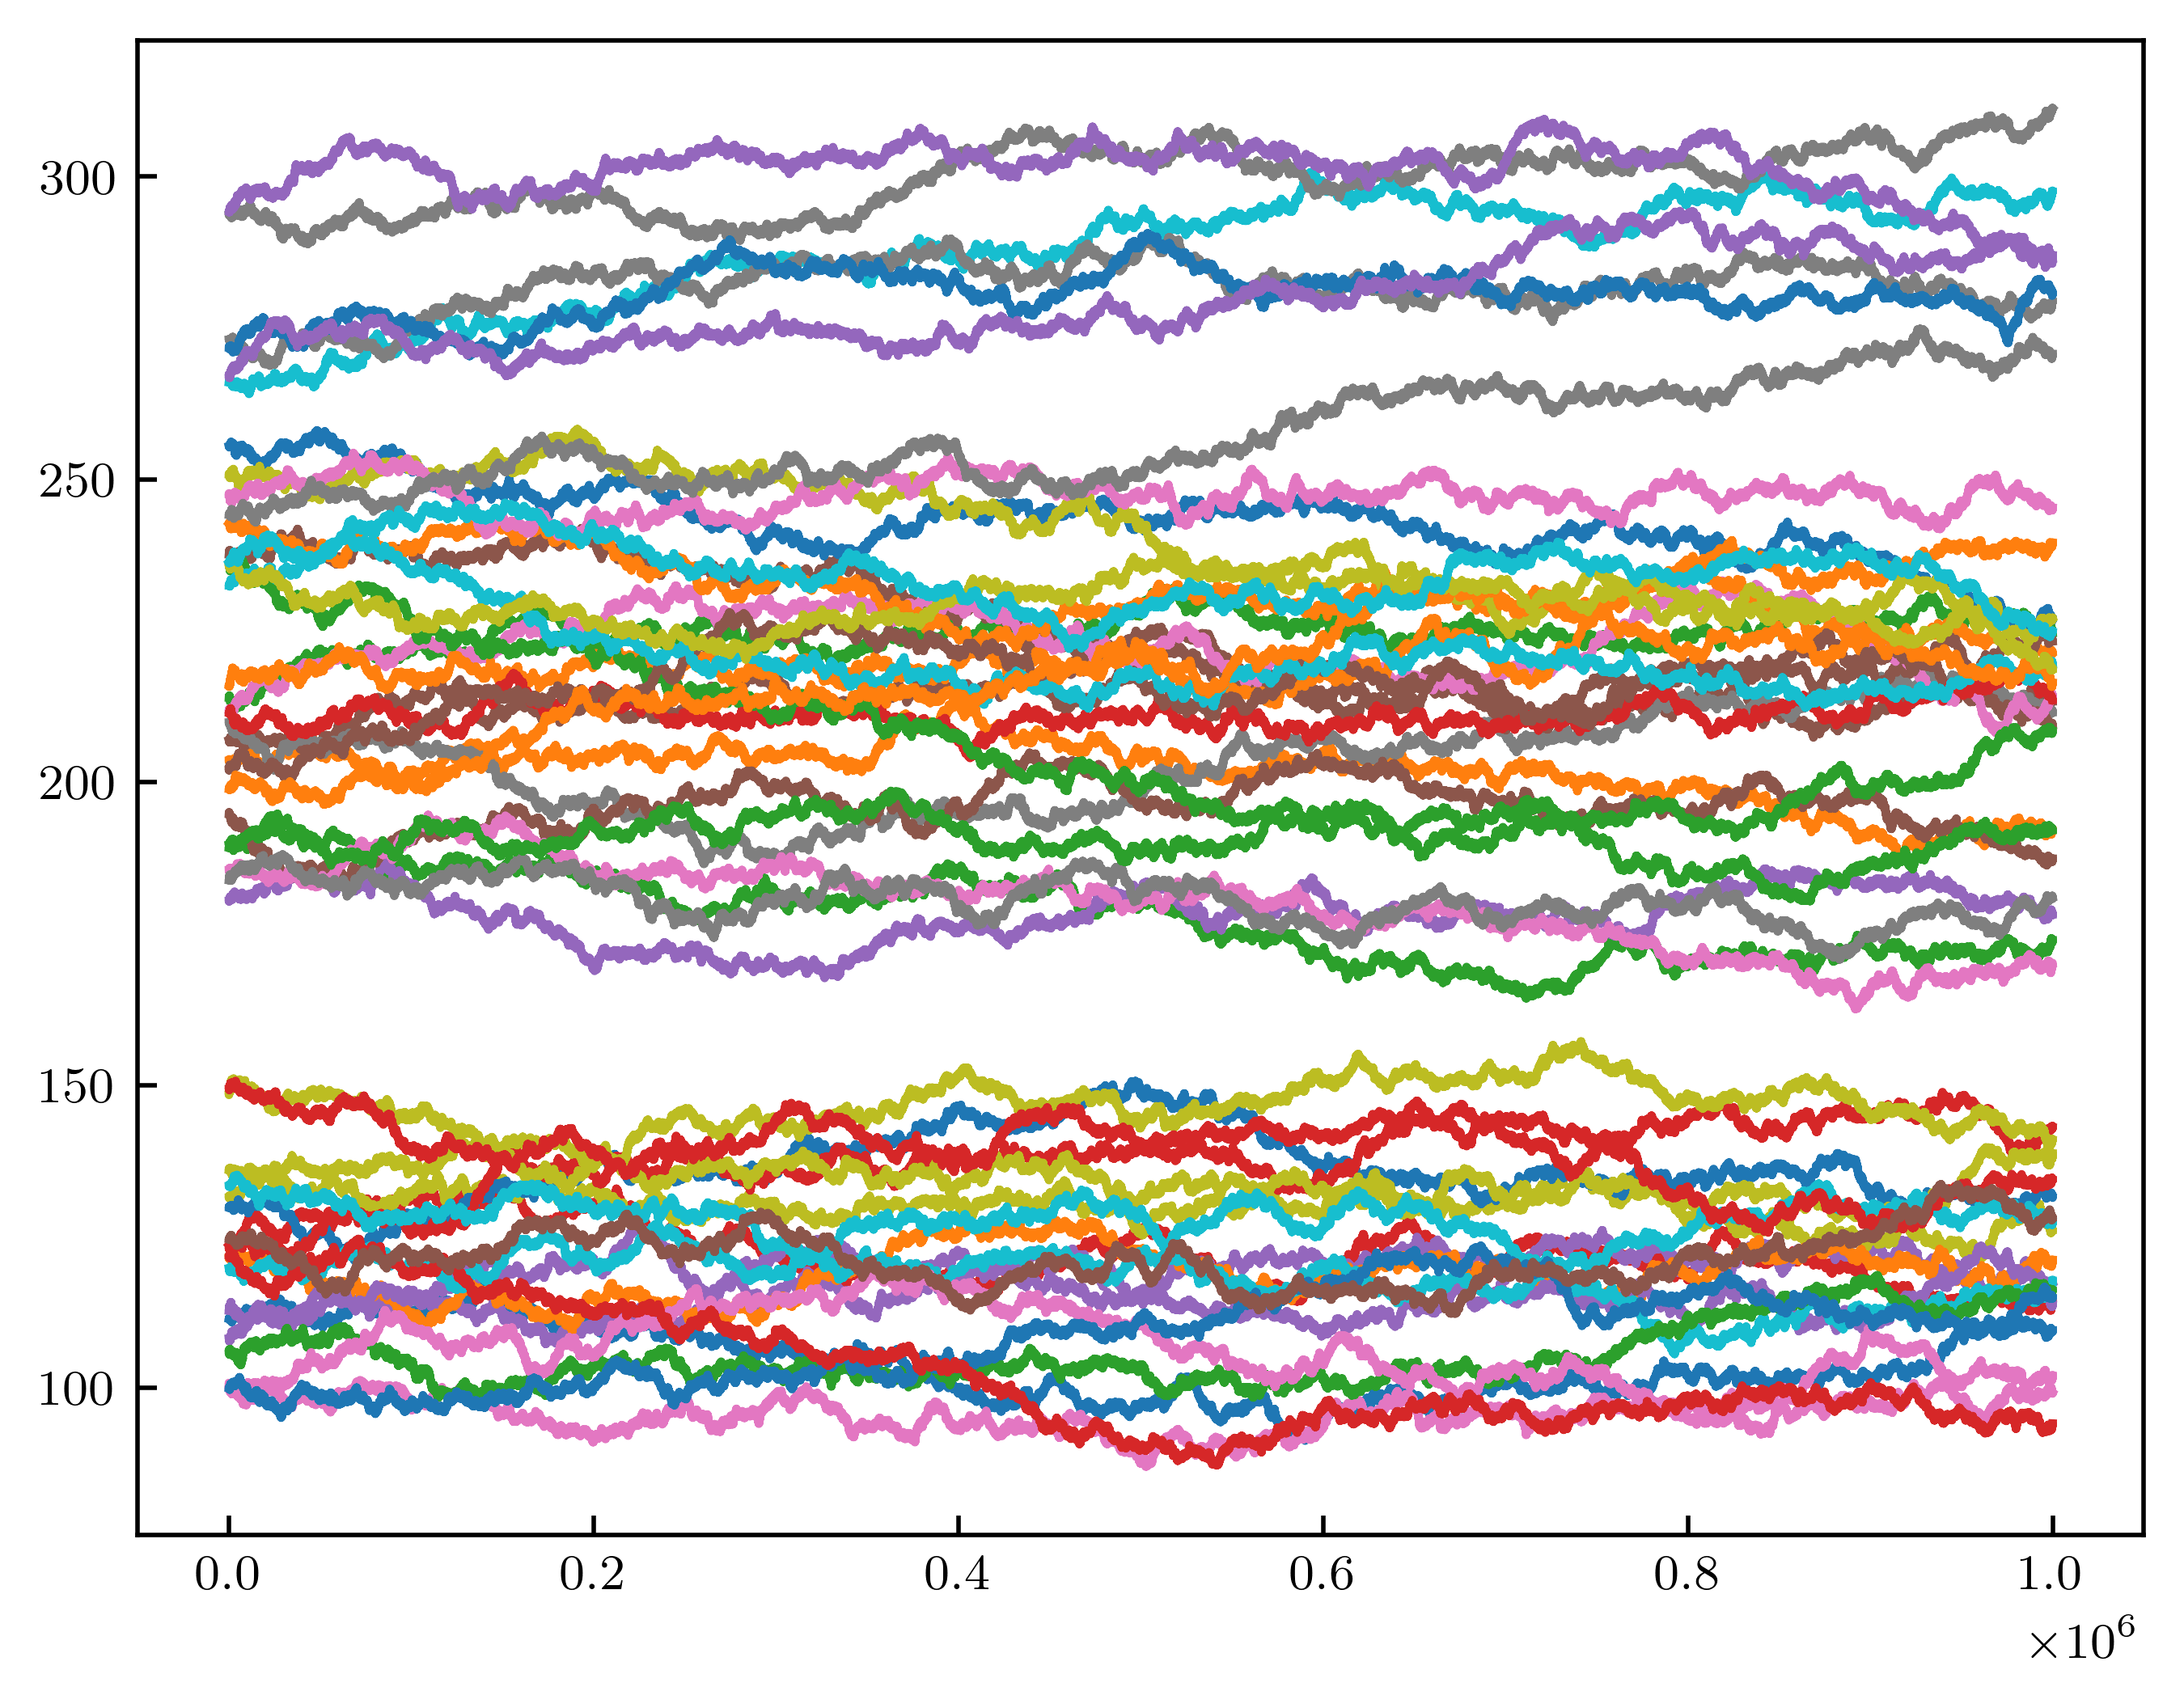

In [548]:
for i in range(N_traj):
    plt.plot(zs[:,i]*1e6)

In [549]:
def measure_Peq(zs, min_distance, max_distance, n_bins, base=2):
    N_traj = zs.shape[1]
    all_x_P_eq, all_width_P_eq, all_y_P_eq = np.zeros((N_traj, n_bins)), np.zeros((N_traj, n_bins)), np.zeros((N_traj, n_bins))
    # Histogram over all the positions z
    for p in range(N_traj):
        z_temp = zs[:,p]
        z_temp = z_temp[~np.isnan(z_temp)]
        x_P_eq_temp, width_P_eq_temp, y_P_eq_temp = logarithmic_hist(zs[:,p], min_distance, max_distance, num=n_bins+1, base=base, density=True)
        all_x_P_eq[p,:] = np.copy(x_P_eq_temp)
        all_width_P_eq[p,:] = np.copy(width_P_eq_temp)
        all_y_P_eq[p,:] = np.copy(y_P_eq_temp)
    x_P_eq = np.nanmean(all_x_P_eq, axis=0)
    width_P_eq = np.nanmean(all_width_P_eq, axis=0)
    y_P_eq = np.nanmean(all_y_P_eq, axis=0)
    del all_x_P_eq, all_width_P_eq, all_y_P_eq
    return x_P_eq, width_P_eq, y_P_eq

In [550]:
min_distance = 20e-9 
max_distance = 400e-6
n_bins = 40

In [551]:
%%time 
x_P_eq, width_P_eq, y_P_eq = measure_Peq(zs[:,:], min_distance, max_distance, n_bins, base=10)

# y_P_eq = y_P_eq / np.trapezoid(y_P_eq, x_P_eq)

CPU times: user 1.97 s, sys: 0 ns, total: 1.97 s
Wall time: 1.97 s


In [552]:
delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 10000, 1000),
        np.arange(10000, 50000, 10000), 
    )
)

delta_time_MSD = delta_frame_nb * dt

In [553]:
from math import sqrt

def moment(n, xs, delta_frame_nb, return_err=False, retrieve_mean=False):
    res = np.zeros_like(delta_frame_nb) * np.nan
    err = np.zeros_like(res) * np.nan
    N_traj = np.shape(xs)[1]
    for i, df in enumerate(delta_frame_nb):
        dxs = xs[df:,:] - xs[:-df,:]
        if retrieve_mean:
            for p in range(N_traj):
                dxs[:,p] = dxs[:,p] - np.nanmean(dxs[:,p])
        dxs_n = dxs ** n 
        res[i] = np.nanmean(dxs_n)
        err[i] = np.nanstd(dxs_n) / sqrt(dxs_n.size)
    if return_err:
        return res, err
    return res

def measure_MSD(xs, delta_frame_nb, return_err=False, retrieve_mean=False):
    return moment(2, xs, delta_frame_nb, return_err=return_err, retrieve_mean=retrieve_mean)

# @njit
# def moment_numba(n, xs, delta_frame_nb):
#     res = np.empty_like(delta_frame_nb, dtype=np.float64)
#     err = np.empty_like(res)
#     N_t, N_traj = np.shape(xs)
#     for i in range(len(delta_frame_nb)):
#         df = delta_frame_nb[i]
#         if df <= 0 or df >= N_t:
#             res[i] = np.nan
#             continue
#         count = N_t - df
#         acc = 0.0
#         std = np.empty(N_traj+count, dtype=np.float64)
#         for j in range(N_traj):
#             for k in range(count):
#                 dx_n = (xs[k+df, j] - xs[k, j]) ** n
#                 acc += dx_n
#                 std
#         std = np.array(std)
#         res[i] = acc / (count * N_traj)
#     return res, err

# def measure_MSD_numba(xs, delta_frame_nb):
#     return moment_numba(2, xs, delta_frame_nb)

In [554]:
%%time 

MSD_x, std_MSD_x = measure_MSD(xs, delta_frame_nb, return_err=True)
MSD_z, std_MSD_z = measure_MSD(zs, delta_frame_nb, return_err=True)

CPU times: user 18.5 s, sys: 6.78 s, total: 25.3 s
Wall time: 25.3 s


In [555]:
D0 = kT / (6*np.pi*eta0*a)

start = 0
stop = 10
coef_MSD_x = np.polyfit(delta_time_MSD[start:stop], MSD_x[start:stop], 1)
coef_MSD_z = np.polyfit(delta_time_MSD[start:stop], MSD_z[start:stop], 1)
meanDx_MSD = coef_MSD_x[0] / 2
meanDz_MSD = coef_MSD_z[0] / 2

In [512]:
zz = np.linspace(1e-9, 100e-6, int(1e6))

meanDx = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_x(zz, a), zz) * D0
meanDz = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_z(zz, a), zz) * D0

def _P_dz_long(dz, B, lD, lB, zz=zz):
    return np.trapezoid(P_eq(zz, B, lD, lB, normalize=False) * P_eq(zz + dz, B, lD, lB, normalize=False), zz)
def P_dz_long(dzz, B, lD, lB, zz=zz):
    res = np.zeros_like(dzz)
    for i in range(len(res)):
        res[i] = _P_dz_long(dzz[i], B, lD, lB, zz=zz)
    res = res / np.trapezoid(res, dzz)
    return res
    
dzz = np.linspace(-10e-6, 10e-6, int(1e3))

plateau_MSDz = np.trapezoid(dzz ** 2 * P_dz_long(dzz, B, lD, lB), dzz)

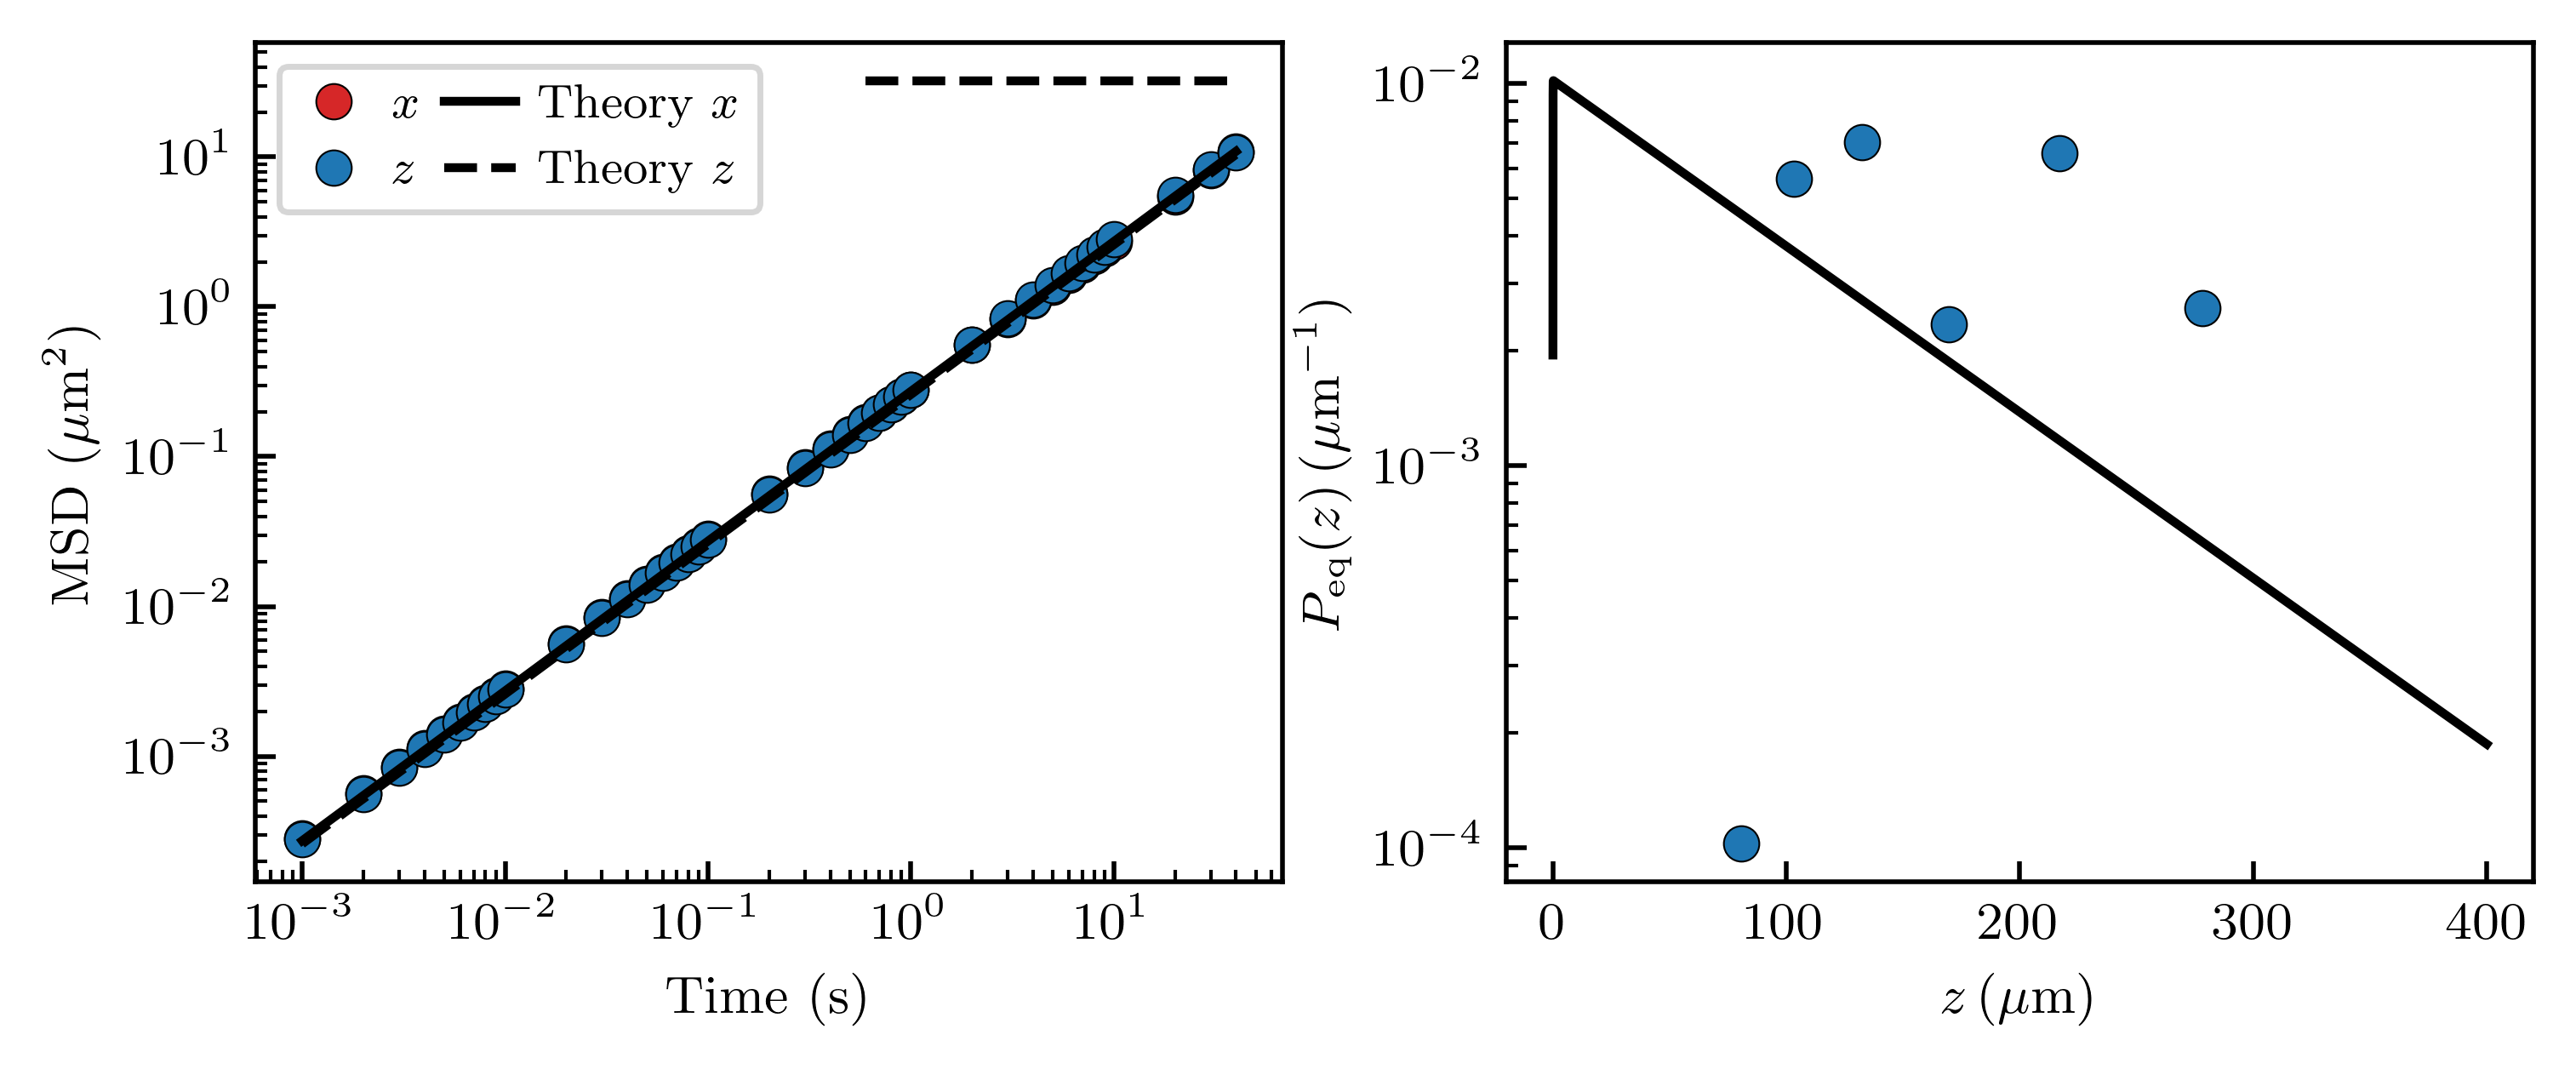

In [556]:
# Plot 

x_P_eq_theory = np.linspace(min_distance, max_distance, int(1e6))
y_P_eq_theory = P_eq(x_P_eq_theory, B, lD, lB, normalize=True)

fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(delta_time_MSD, MSD_x*1e12, 'o', mfc='tab:red', label=r'$x$')
axes[0].plot(delta_time_MSD, MSD_z*1e12, 'o', mfc='tab:blue', label=r'$z$')
axes[0].plot(delta_time_MSD, 2 * meanDx * delta_time_MSD * 1e12, ls='-', c='k', label=r'Theory $x$')
axes[0].plot(delta_time_MSD, 2 * meanDz * delta_time_MSD * 1e12, ls='--', c='k', label=r'Theory $z$')
dtime_MSD_long = delta_time_MSD[delta_time_MSD > 0.5]
axes[0].plot(dtime_MSD_long, np.ones_like(dtime_MSD_long) * plateau_MSDz * 1e12, ls='--', c='k')
axes[0].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
axes[0].set(xlabel='Time (s)', ylabel=r'MSD $(\mathrm{\mu m ^2})$', xscale='log', yscale='log')
axes[1].plot(x_P_eq*1e6, y_P_eq*1e-6, 'o', mfc='tab:blue')

# for p in range(N_traj):
#     x_P_eq_temp, width_P_eq_temp, y_P_eq_temp = measure_Peq(zs[:,p:p+1], min_distance, max_distance, n_bins, base=10)
#     axes[1].plot(x_P_eq_temp*1e6, y_P_eq_temp*1e-6, ls='-', c='gray', linewidth=0.3)
    
axes[1].plot(x_P_eq_theory*1e6, y_P_eq_theory*1e-6, ls='-', c='k')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$P_\mathrm{eq}(z) \, \mathrm{(\mu m ^{-1})}$', xscale='linear', yscale='log')

plt.tight_layout(pad=0.2)
plt.show()

In [557]:
# start = 0
# stop = 10
# coef_MSD_x = np.polyfit(delta_time_MSD[start:stop], MSD_x[start:stop], 1)
# coef_MSD_z = np.polyfit(delta_time_MSD[start:stop], MSD_z[start:stop], 1)
# mean_Dx_MSD = coef_MSD_x[0] / 2
# mean_Dz_MSD = coef_MSD_z[0] / 2

In [558]:
# fig.savefig('MSD_Peq.pdf', transparent=True)

## First-Passage Times

In [559]:
@njit
def get_FPT_one_particle(x, l):
    Ntot = len(x)
    res = []
    for i in range(Ntot):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + l:
            j += 1
            c += 1
            if j >= Ntot:
                c = np.nan
                break
        res.append(c)
        # Maybe: add a condition to break the loop if several FPTs in a row are nans
    res = np.array(res)
    res = res * dt
    return res

# @njit
def get_FPT_several_particles(xs, Ls):
    res = []
    N_traj = np.shape(xs)[1]
    for k in range(len(Ls)):
        l = Ls[k]
        fpt_temp = np.zeros_like(xs) * np.nan
        for p in tqdm(range(N_traj)):
            fpt_one_p = get_FPT_one_particle(xs[:,p], l)
            fpt_temp[:len(fpt_one_p),p] = fpt_one_p
        res.append(fpt_temp)
        print("L = {} um done.".format(np.round(l*1e6,2)))
    return res

In [560]:
Ls = [250e-9]

In [561]:
%%time

FPT_x = get_FPT_several_particles(xs, Ls)

  8%|███▌                                        | 4/50 [02:31<29:05, 37.94s/it]


KeyboardInterrupt: 

In [562]:
k = 0

fpt_x = FPT_x[k][~np.isnan(FPT_x[k])]

print(np.shape(fpt_x))

bins_FPT_x, _, hist_FPT_x = co.logarithmic_hist(fpt_x, begin=dt, stop=Nt*dt, num=100, base=10, )

bins_FPT_x_theory = np.logspace(np.log10(np.min(bins_FPT_x)), np.log10(np.max(bins_FPT_x)), 1000)
hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=Ls[k], D=meanDx)

x_to_be_fitted = np.copy(bins_FPT_x)
y_to_be_fitted = np.copy(hist_FPT_x)
x_to_be_fitted = bins_FPT_x[y_to_be_fitted > 0]
y_to_be_fitted = np.log10(y_to_be_fitted[y_to_be_fitted > 0])

popt, _ = curve_fit(lambda t, D: np.log10(Levy(t, L=Ls[k], D=D)), x_to_be_fitted, y_to_be_fitted, p0=[meanDx]) # /!\ log fit
hist_FPT_x_fit = Levy(bins_FPT_x_theory, L=Ls[k], D=popt[0])

(4881755,)


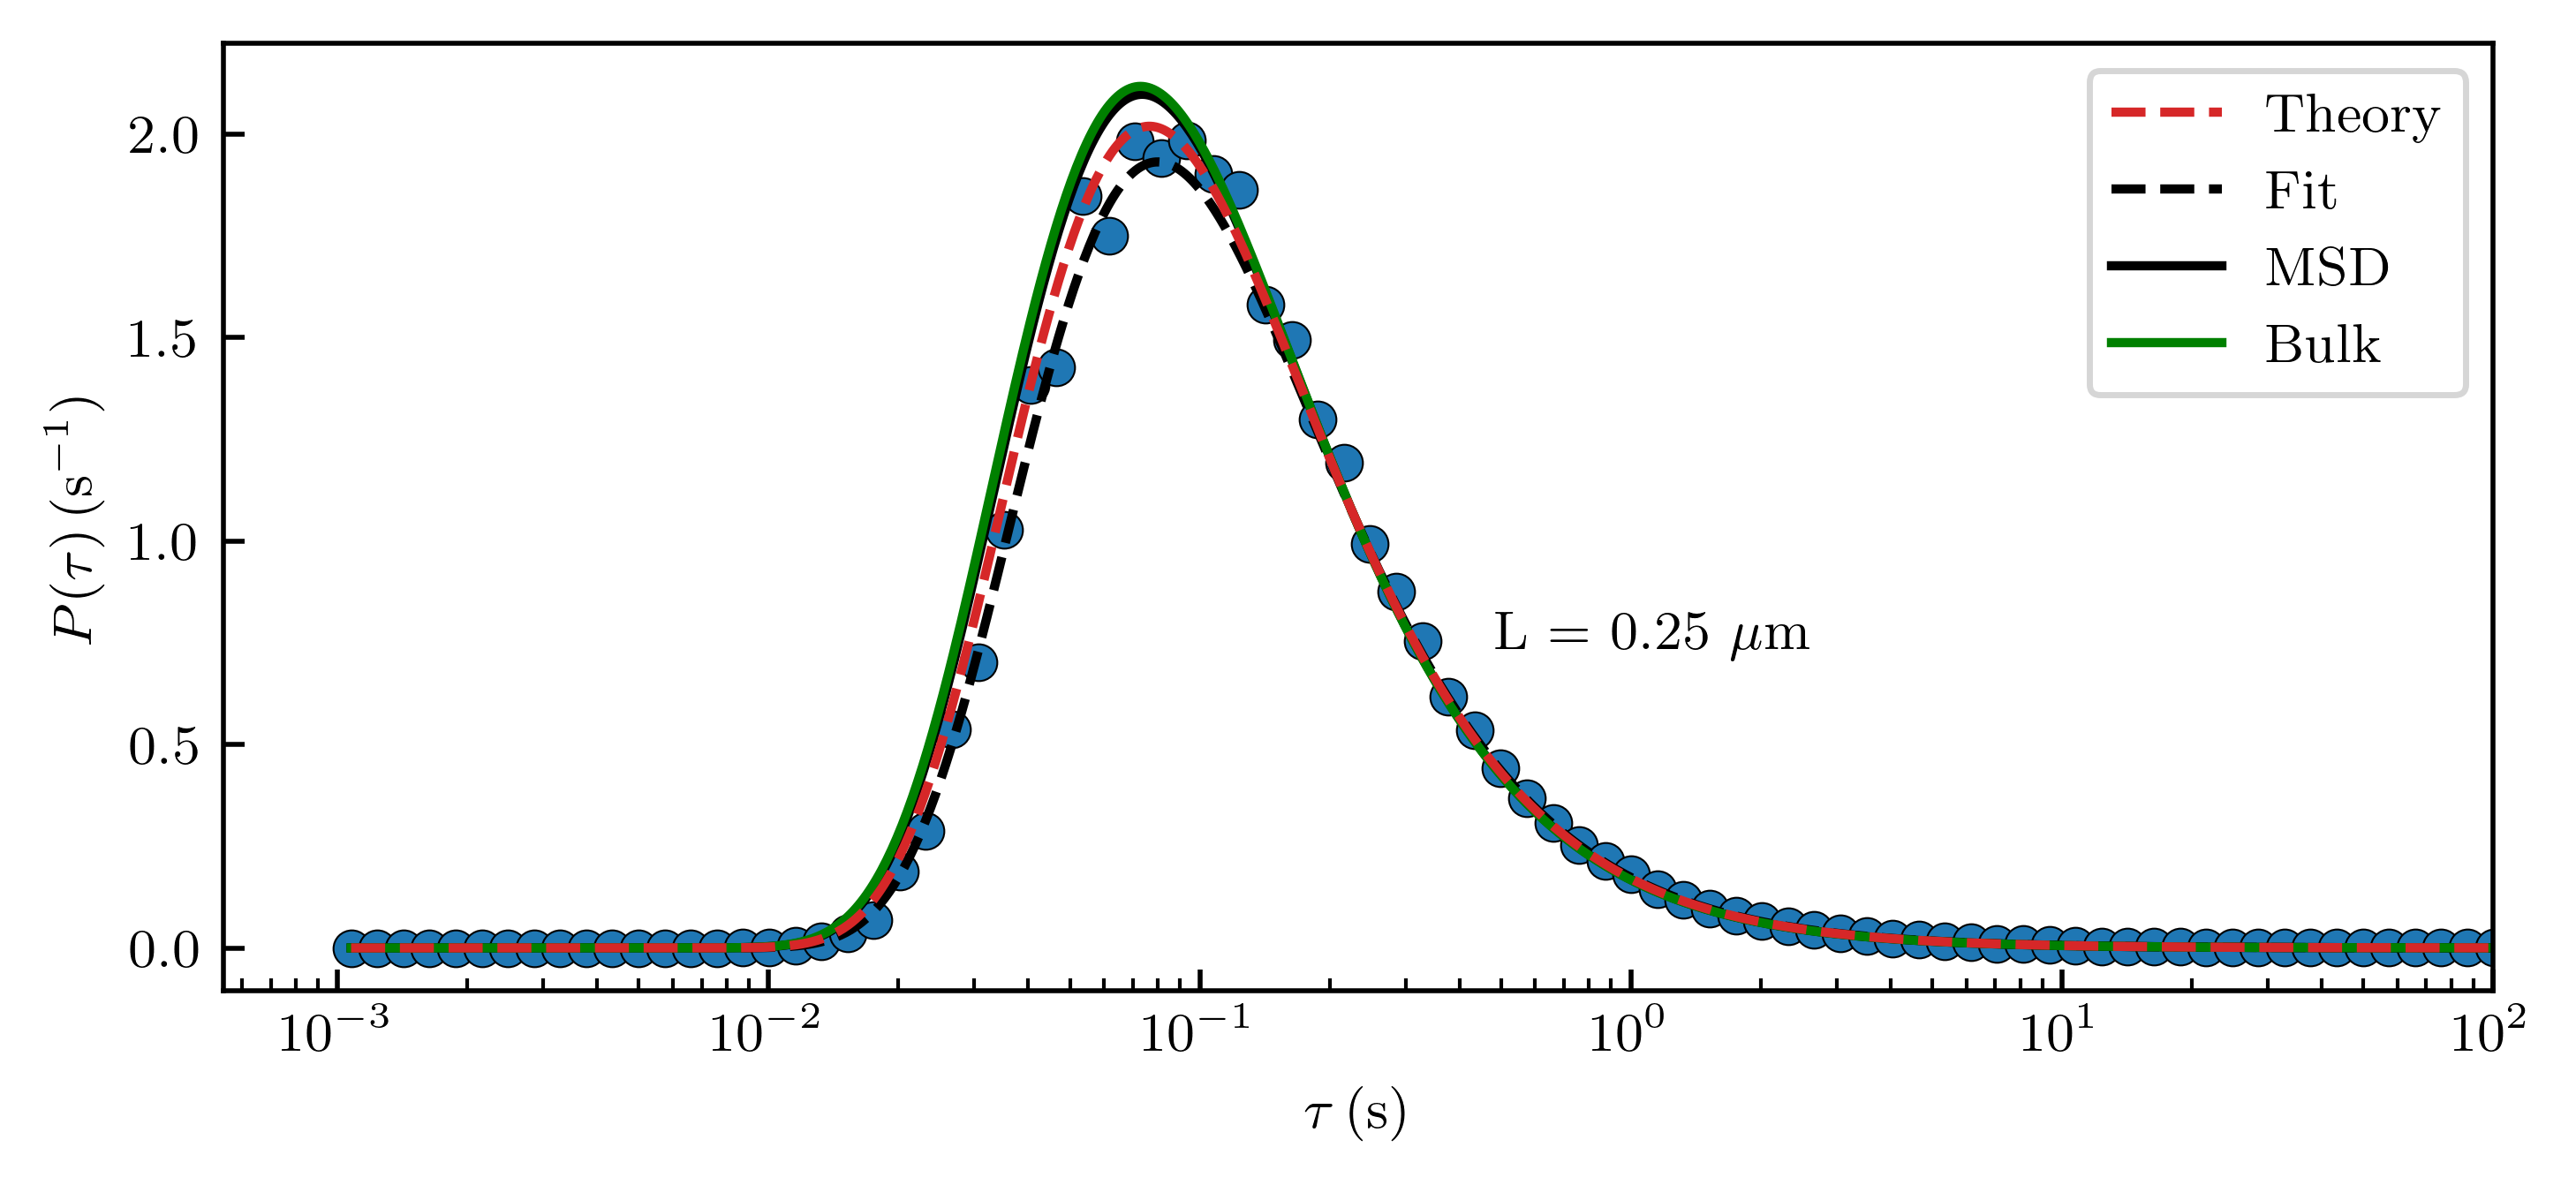

In [563]:
fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.plot(bins_FPT_x, hist_FPT_x, 'o')
ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--', c='tab:red', label=r'Theory', zorder=3)
ax.plot(bins_FPT_x_theory, hist_FPT_x_fit, '--k', label='Fit')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=Ls[k], D=meanDx_MSD), '-k', label='MSD')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=Ls[k], D=D0), '-g', label='Bulk')
ax.set(xscale='log', yscale='linear', xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$', xlim=[None, 100])
ax.legend()
ax.annotate(
    r"L = {} $\mu$m".format(np.round(Ls[k] * 1e6, 3)), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.4), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
    fontsize=9, 
)
plt.tight_layout()
plt.show()

In [564]:
# fig.savefig('FPT_x.pdf')

In [565]:
meanDx_MSD / D0

np.float64(0.9908106795011679)

In [566]:
meanDx / D0

np.float64(0.9537266318482639)

In [567]:
D0

1.430060215328377e-13

In [568]:
# save['delta_frame_nb'] = np.copy(delta_frame_nb)
# save['delta_time_MSD'] = np.copy(delta_time_MSD)
# save['MSD_x'] = np.copy(MSD_x)
# save['MSD_z'] = np.copy(MSD_z)
# save['mean_Dx_MSD'] = np.copy(mean_Dx_MSD)
# save['mean_Dz_MSD'] = np.copy(mean_Dz_MSD)
# save['D0'] = D0
# save['x_P_eq'] = np.copy(x_P_eq)
# save['y_P_eq'] = np.copy(y_P_eq)

# #save['timesteps_dx'] = np.copy(timesteps_dx)
# #save['timesteps_dz'] = np.copy(timesteps_dz)
# #save['n_std'] = n_std
# #save['bins_dx'] = np.copy(bins_dx)
# #save['bins_dz'] = np.copy(bins_dz)
# #save['prob_dx'] = np.copy(prob_dx)
# #save['prob_dz'] = np.copy(prob_dz)

# save['Ls'] = copy.deepcopy(Ls)
# save['bins_FPT_x'] = np.copy(bins_FPT_x)
# save['hist_FPT_x'] = np.copy(hist_FPT_x)


# # Theoretical = expected values 
# save['mean_Dx_theory'] = meanDx
# save['mean_Dz_theory'] = meanDz
# save['plateau_MSDz_theory'] = plateau_MSDz
# save['x_P_eq_theory'] = np.copy(x_P_eq_theory)
# save['y_P_eq_theory'] = np.copy(y_P_eq_theory)

In [569]:
#savemat('simu_rigid_like_trajs_AR1000_in_water_20250624.mat', save)

# Compute N >> Trajectories and Analyze

Code to compute a huge nb of trajectories, save them individually in a folder. Later analyze all the trajectories, but not loading all of them at the same time. 

In [570]:
# Test to get the bins' edges for the distributions of displacements 
timesteps = np.array([1, 10, 100])
std_dx = np.zeros_like(timesteps, dtype=float)
std_dz = np.zeros_like(timesteps, dtype=float)
for i, di in enumerate(timesteps):
    dx = xs[di:,:] - xs[:-di,:]
    dz = zs[di:,:] - zs[:-di,:]
    print(di)
    print(np.min(dx), np.max(dx))
    print(np.min(dz), np.max(dz))
    std_dx[i] = np.nanstd(dx)
    std_dz[i] = np.nanstd(dz)
    print()

print(std_dx)
print(std_dz)

1
-9.528922243609897e-08 9.406081132314298e-08
-9.895279244754435e-08 9.119303935928758e-08

10
-2.858921759768062e-07 2.976430653783757e-07
-3.092915457209418e-07 2.832753375533049e-07

100
-8.359878315315137e-07 9.141219153513156e-07
-8.578383125381435e-07 8.775845033649646e-07

[1.68338272e-08 5.32339542e-08 1.68290525e-07]
[1.67491411e-08 5.29610970e-08 1.67491769e-07]


In [571]:
# Compute trajectories 

def compute_one_traj(i, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, R0=None):
    brown = DoubleWallsLangevin(
        dt=dt, Nt=Nt, Nt_sub=Nt_sub, 
        a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
        R0=R0, 
    )
    brown.trajectory()
    x = brown.Xn
    z = brown.Zn + H
    return x, z

def unravel_N_traj(res):
    xs = np.zeros((np.shape(res)[2], np.shape(res)[0]))
    zs = np.zeros((np.shape(res)[2], np.shape(res)[0]))
    for j in range(np.shape(res)[0]):
        xs[:,j] = res[j][0]
        zs[:,j] = res[j][1]
    return xs, zs

def compute_N_traj(Ncpu, N, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, R0s):
    params = [(i, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, R0s[i]) for i in np.arange(N)]
    with Pool(Ncpu) as p:
        res = p.starmap(compute_one_traj, params)
    xs, zs = unravel_N_traj(res)
    return xs, zs

In [572]:
# Compute Peq over N trajectories 

def log_hist(data, bins_edges, density=True):
    widths = bins_edges[1:] - bins_edges[:-1]
    hist, bins = np.histogram(data, bins=bins_edges, density=density)
    bins_center = (bins[1:] + bins[:-1]) / 2
    return bins_center, widths, hist

def measure_Peq(zs, bins_edges):
    N_traj = zs.shape[1]
    all_x_P_eq, all_width_P_eq, all_y_P_eq = np.zeros((N_traj, n_bins)), np.zeros((N_traj, n_bins)), np.zeros((N_traj, n_bins))
    # Histogram over all the positions z
    for p in range(N_traj):
        z_temp = zs[:,p]
        z_temp = z_temp[~np.isnan(z_temp)]
        x_P_eq_temp, width_P_eq_temp, y_P_eq_temp = log_hist(zs[:,p], bins_edges, density=True)
        all_x_P_eq[p,:] = np.copy(x_P_eq_temp)
        all_width_P_eq[p,:] = np.copy(width_P_eq_temp)
        all_y_P_eq[p,:] = np.copy(y_P_eq_temp)
    x_P_eq = np.nanmean(all_x_P_eq, axis=0)
    width_P_eq = np.nanmean(all_width_P_eq, axis=0)
    y_P_eq = np.nanmean(all_y_P_eq, axis=0)
    del all_x_P_eq, all_width_P_eq, all_y_P_eq
    return x_P_eq, width_P_eq, y_P_eq

In [573]:
# Compute MSDs from N trajectories 

from math import sqrt

def moment(n, xs, delta_frame_nb, return_err=False, retrieve_mean=False):
    res = np.zeros_like(delta_frame_nb) * np.nan
    err = np.zeros_like(res) * np.nan
    N_traj = np.shape(xs)[1]
    for i, df in enumerate(delta_frame_nb):
        dxs = xs[df:,:] - xs[:-df,:]
        if retrieve_mean:
            for p in range(N_traj):
                dxs[:,p] = dxs[:,p] - np.nanmean(dxs[:,p])
        dxs_n = dxs ** n 
        res[i] = np.nanmean(dxs_n)
        err[i] = np.nanstd(dxs_n) / sqrt(dxs_n.size)
    if return_err:
        return res, err
    return res

def measure_MSD(xs, delta_frame_nb, return_err=False, retrieve_mean=False):
    return moment(2, xs, delta_frame_nb, return_err=return_err, retrieve_mean=retrieve_mean)

# Get mean diffusion coefficients from these MSDs

# D0 = kT / (6*np.pi*eta0*a)

def get_diffusivity_from_MSD(delta_time_MSD, MSD, start=0, stop=10):
    coef_MSD = np.polyfit(delta_time_MSD[start:stop], MSD[start:stop], 1)
    return coef_MSD[0] / 2

def get_diffusivities_from_MSD(delta_time_MSD, MSD_x, MSD_z, start=0, stop=10):
    meanDx_MSD = get_diffusivity_from_MSD(delta_time_MSD, MSD_x, start=0, stop=10)
    meanDz_MSD = get_diffusivity_from_MSD(delta_time_MSD, MSD_z, start=0, stop=10)
    return meanDx_MSD, meanDz_MSD

In [574]:
# Compute P of displacements from N trajectories 

def pdf(data, bin_edges, density=True):
    pdf, bins_edge = np.histogram(
        data, 
        bins=bin_edges, 
        density=density, 
    )
    bins_center = (bins_edge[:-1] + bins_edge[1:]) / 2
    return pdf, bins_center

# Compute proba of displacements 
def _compute_proba_dx(x, di, bin_edges, use_cutoff=3, min_dx=None):
    dx = x[di:,:] - x[:-di,:]
    if use_cutoff != None:
        cutoff = use_cutoff * np.nanstd(dx)
        index = np.abs(dx) < cutoff
        dx = dx[index]
    if min_dx != None:
        index = np.abs(dx) >= min_dx
        dx = dx[index]
    hist, bin_centers = pdf(dx[~np.isnan(dx)], bin_edges, density=True)
    # hist = hist / np.trapezoid(hist, bins_center)
    # bins_center_norm = bins_center / np.std(dx)
    # hist_norm = hist / np.trapezoid(hist, bins_center / np.std(dx))
    return hist, bin_centers #, hist_norm, bins_center_norm

def compute_proba_dx(str_x, use_cutoff=3, min_dx=None):
    x = str2var(str_x + 's')
    timesteps = str2var('timesteps_d' + str_x)
    bin_edges = str2var('bin_edges_d' + str_x)
    res = np.zeros((len(timesteps), np.shape(bin_edges)[1]-1))
    for n, di in enumerate(timesteps):
        hist, _ = _compute_proba_dx(x, di, bin_edges=bin_edges[n], use_cutoff=use_cutoff, min_dx=min_dx)
        # hist, bins_center, hist_norm, bins_center_norm = _compute_proba_dx(x, di, bins=bins, use_cutoff=use_cutoff, min_dx=min_dx)
        # res["proba_d{0}_short_t_{1}".format(str_x, di)] = [np.copy(bins_center), np.copy(hist)]
        # res["normalized_proba_d{0}_short_t_{1}".format(str_x, di)] = [np.copy(bins_center_norm), np.copy(hist_norm)]
        res[n,:] = np.copy(hist)
    return res

# # Get back computed proba of displacements
# def get_back_proba(str_x, n=0):
#     probas = str2var('probas_d' + str_x)
#     timesteps = str2var('timesteps_d' + str_x)
#     di = timesteps[n]
#     which = "proba_d{0}_short_t_{1}".format(str_x, di)
#     prob = probas[which]
#     return prob

In [575]:
@njit
def get_FPT_one_particle(x, l, offset=0):
    Ntot = len(x)
    res = []
    for i in range(Ntot-offset):
        x0 = x[i]
        j = i #+ offset
        c = 0
        while x[j] < x0 + l:
            j += 1
            c += 1
            if j >= Ntot:
                c = np.nan
                break
        res.append(c)
        # Maybe: add a condition to break the loop if several FPTs in a row are nans
    res = np.array(res)
    # res = res[~np.isnan(res)]
    res = res * dt
    return res

# def get_FPT_one_particle_bis(x, l, offset=0):
#     Ntot = len(x)
#     res = np.zeros_like(x)
#     for i in range(Ntot-offset):
#         c = np.argmax(x[i+offset:] >= x[i]+l)
#         res[i] = offset + c
#     res = np.array(res)
#     res = res * dt
#     return res

# def get_FPT_several_particles(xs, Ls, offset=0):
#     res = []
#     N_traj = np.shape(xs)[1]
#     for k in range(len(Ls)):
#         l = Ls[k]
#         fpt_temp = np.zeros_like(xs) * np.nan
#         for p in range(N_traj):
#             fpt_one_p = get_FPT_one_particle(xs[:,p], l, offset=offset)
#             fpt_temp[:len(fpt_one_p),p] = fpt_one_p
#         res.append(fpt_temp)
#     return res

# def _get_hist_FPT(fpt_x, bin_edges):
#     fpt_x = fpt_x[~np.isnan(fpt_x)]
#     bins_FPT_x, _, hist_FPT_x = log_hist(fpt_x, bin_edges, density=True)
#     return hist_FPT_x
    
# def get_hist_FPT(xs, Ls, bins_edges, offset=0):
#     FPT_x = get_FPT_several_particles(xs, Ls, offset=offset)
#     res = np.zeros((len(Ls), np.shape(bins_edges)[1]-1))
#     for k, L in enumerate(Ls):
#         fpt_x = FPT_x[k]
#         bin_edges = bins_edges[k,:]
#         res[k,:] = _get_hist_FPT(fpt_x, bin_edges) # bins_edges = one array for each L of Ls
#     return res

def _get_FPT_several_particles(i, xs, Ls, offset=0):
    x = np.copy(xs[:,i])
    res = []
    for k in range(len(Ls)):
        l = Ls[k]
        fpt_one_p = get_FPT_one_particle(x, l, offset=offset)
        res.append(fpt_one_p[~np.isnan(fpt_one_p)])
        # res = fpt_one_p[~np.isnan(fpt_one_p)]
    return res
    
def get_FPT_several_particles(Ncpu, xs, Ls, offset=0):
    with Pool(Ncpu) as p:
        temp = p.starmap(_get_FPT_several_particles, [(i,xs,Ls) for i in range(np.shape(xs)[1])])
    # temp = np.array(temp)
    res = []
    for j in range(len(Ls)):
        tempres = np.concatenate([temp[i][j] for i in range(len(temp))])
        tempres = tempres[~np.isnan(tempres)]
        res.append(tempres)
    return res

def _get_hist_FPT(fpt_x, bin_edges):
    fpt_x = fpt_x[~np.isnan(fpt_x)]
    bins_FPT_x, _, hist_FPT_x = log_hist(fpt_x, bin_edges, density=True)
    return hist_FPT_x
    
def get_hist_FPT(Ncpu, xs, Ls, bins_edges, offset=0):
    FPT_x = get_FPT_several_particles(Ncpu, xs, Ls, offset=offset)
    res = np.zeros((len(Ls), np.shape(bins_edges)[1]-1))
    for k, L in enumerate(Ls):
        fpt_x = FPT_x[k]
        bin_edges = bins_edges[k,:]
        res[k,:] = _get_hist_FPT(fpt_x, bin_edges) # bins_edges = one array for each L of Ls
    return res

In [641]:
# Define parameters

Nt = 1_000_000
dt_num = 1e-3
Nt_sub = 1
dt = dt_num * Nt_sub

print('Electrostatics and gravity: B = {0}, lD = {1} nm, and lB = {2} nm'.format(B, lD*1e9, lB*1e9))
print('Physical timestep = {} s'.format(dt))

N1 = 1 #12500 // 2
N2 = 16
Ntot = int(N1*N2)
print()
print('Total nb of points = {:0.1e}'.format(N1*N2*Nt))

# Initialize variables 

# MSD
delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 10000, 1000),
        np.arange(10000, 100000, 10000), 
    )
)
delta_time_MSD = delta_frame_nb * dt
MSD_x = np.zeros_like(delta_time_MSD)
MSD_z = np.zeros_like(delta_time_MSD)
mean_Dx_MSD = np.zeros(N1)
mean_Dz_MSD = np.zeros(N1)

# Peq
min_distance = 20e-9 
max_distance = 400e-6
n_bins = 20
bins_edges = np.logspace(np.log10(min_distance), np.log10(max_distance), n_bins+1, base=10, dtype=np.float64)
x_P_eq = (bins_edges[1:] + bins_edges[:-1]) / 2
y_P_eq = np.zeros_like(x_P_eq)

# P of displacements
timesteps_dx = timesteps
timesteps_dz = timesteps_dx
n_std = 10
n_bin = 80
bin_edges_dx = [np.linspace(-n_std*std_dx[i], n_std*std_dx[i], n_bin+1) for i in range(len(timesteps_dx))]
bin_edges_dz = [np.linspace(-n_std*std_dz[i], n_std*std_dz[i], n_bin+1) for i in range(len(timesteps_dz))]
bins_dx = np.array([(bin_edges[1:] + bin_edges[:-1]) / 2 for bin_edges in bin_edges_dx])
bins_dz = np.array([(bin_edges[1:] + bin_edges[:-1]) / 2 for bin_edges in bin_edges_dz])
prob_dx = np.array([np.zeros_like(bins) for bins in bins_dx])
prob_dz = np.array([np.zeros_like(bins) for bins in bins_dz])

# FPTs
Ls = [500e-9]
Ls_z = [100e-9]
n_bins_fpt = 100



bin_edges_fpt_x = np.array([np.logspace(np.log10(dt), np.log10(Nt*dt), n_bins_fpt+1) for i in range(len(Ls))])
bin_edges_fpt_z = np.array([np.logspace(np.log10(dt), np.log10(Nt*dt), n_bins_fpt+1) for i in range(len(Ls_z))])


bins_FPT_x = np.array([(bin_edges_fpt_x[i,1:] + bin_edges_fpt_x[i,:-1]) / 2 for i in range(len(Ls))])
hist_FPT_x = np.array([np.zeros_like(bins_FPT_x[i]) for i in range(len(Ls))])
bins_FPT_z = np.array([(bin_edges_fpt_z[i,1:] + bin_edges_fpt_z[i,:-1]) / 2 for i in range(len(Ls_z))])
hist_FPT_z = np.array([np.zeros_like(bins_FPT_z[i]) for i in range(len(Ls_z))])


# /!\ bin_edge_fpt_x must be defined properly!


# all_MSD_x = np.zeros((len(delta_time_MSD), N1))
# all_MSD_z = np.zeros((len(delta_time_MSD), N1))
# all_y_P_eq = np.zeros((len(x_P_eq), N1))

# save_dir = './trajectories_grouped_simulations/'

Electrostatics and gravity: B = 4.5, lD = 20.0 nm, and lB = 100000.0 nm
Physical timestep = 0.001 s

Total nb of points = 1.6e+07


In [642]:
# Simulations

Ncpu = 16

# Initiate class for simulations
brown = DoubleWallsLangevin(
    dt=dt_num, Nt=Nt, Nt_sub=Nt_sub, 
    a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
    R0=None, 
)

for i in tqdm(range(N1)):
    # Initial conditions
    # z0s = brown.return_samples(N2)
    z0s = np.random.uniform(-H/2,H/2,N2)
    # Compute trajectories 
    R0s = [(0, z0s[j]) for j in range(N2)]
    # R0s = [None for j in range(N2)]
    xs, zs = compute_N_traj(Ncpu, N2, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, R0s)
    # Compute Peq
    _, _, temp_y_P_eq = measure_Peq(zs, bins_edges)
    # Compute MSD
    temp_MSD_x, _ = measure_MSD(xs, delta_frame_nb, return_err=True)
    temp_MSD_z, _ = measure_MSD(zs, delta_frame_nb, return_err=True)
    # Compute diffusivities and save 
    mean_Dx_MSD[i], mean_Dz_MSD[i] = get_diffusivities_from_MSD(delta_time_MSD, temp_MSD_x, temp_MSD_z)
    # Compute distributions of displacements 
    temp_prob_dx = compute_proba_dx('x', use_cutoff=n_std, min_dx=None)
    temp_prob_dz = compute_proba_dx('z', use_cutoff=n_std, min_dx=None)
    # Compute FPTs
    temp_hist_FPT_x = get_hist_FPT(Ncpu, xs, Ls, bin_edges_fpt_x, offset=0)
    temp_hist_FPT_z = get_hist_FPT(Ncpu, zs, Ls_z, bin_edges_fpt_z, offset=0)
    # Update variables 
    y_P_eq = y_P_eq + temp_y_P_eq
    MSD_x = MSD_x + temp_MSD_x
    MSD_z = MSD_z + temp_MSD_z
    prob_dx = prob_dx + temp_prob_dx
    prob_dz = prob_dz + temp_prob_dz
    hist_FPT_x = hist_FPT_x + temp_hist_FPT_x
    hist_FPT_z = hist_FPT_z + temp_hist_FPT_z
    # Nap nap
    time.sleep(1)
    
# Finish averaging
y_P_eq = y_P_eq / N1
MSD_x = MSD_x / N1
MSD_z = MSD_z / N1
prob_dx = prob_dx / N1
prob_dz = prob_dz / N1
hist_FPT_x = hist_FPT_x / N1
hist_FPT_z = hist_FPT_z / N1

100%|█████████████████████████████████████████████| 1/1 [00:57<00:00, 57.81s/it]


In [643]:
xs[:,0] == xs[:,1]

array([ True, False, False, ..., False, False, False])

In [644]:
zs[:,0] == zs[:,1]

array([False, False, False, ..., False, False, False])

In [645]:
100 / 24

4.166666666666667

In [646]:
30 * 100 / 3600

0.8333333333333334

In [647]:
# # Finish averaging

# N1 = 67

# y_P_eq = y_P_eq / N1
# MSD_x = MSD_x / N1
# MSD_z = MSD_z / N1
# prob_dx = prob_dx / N1
# prob_dz = prob_dz / N1
# hist_FPT_x = hist_FPT_x / N1

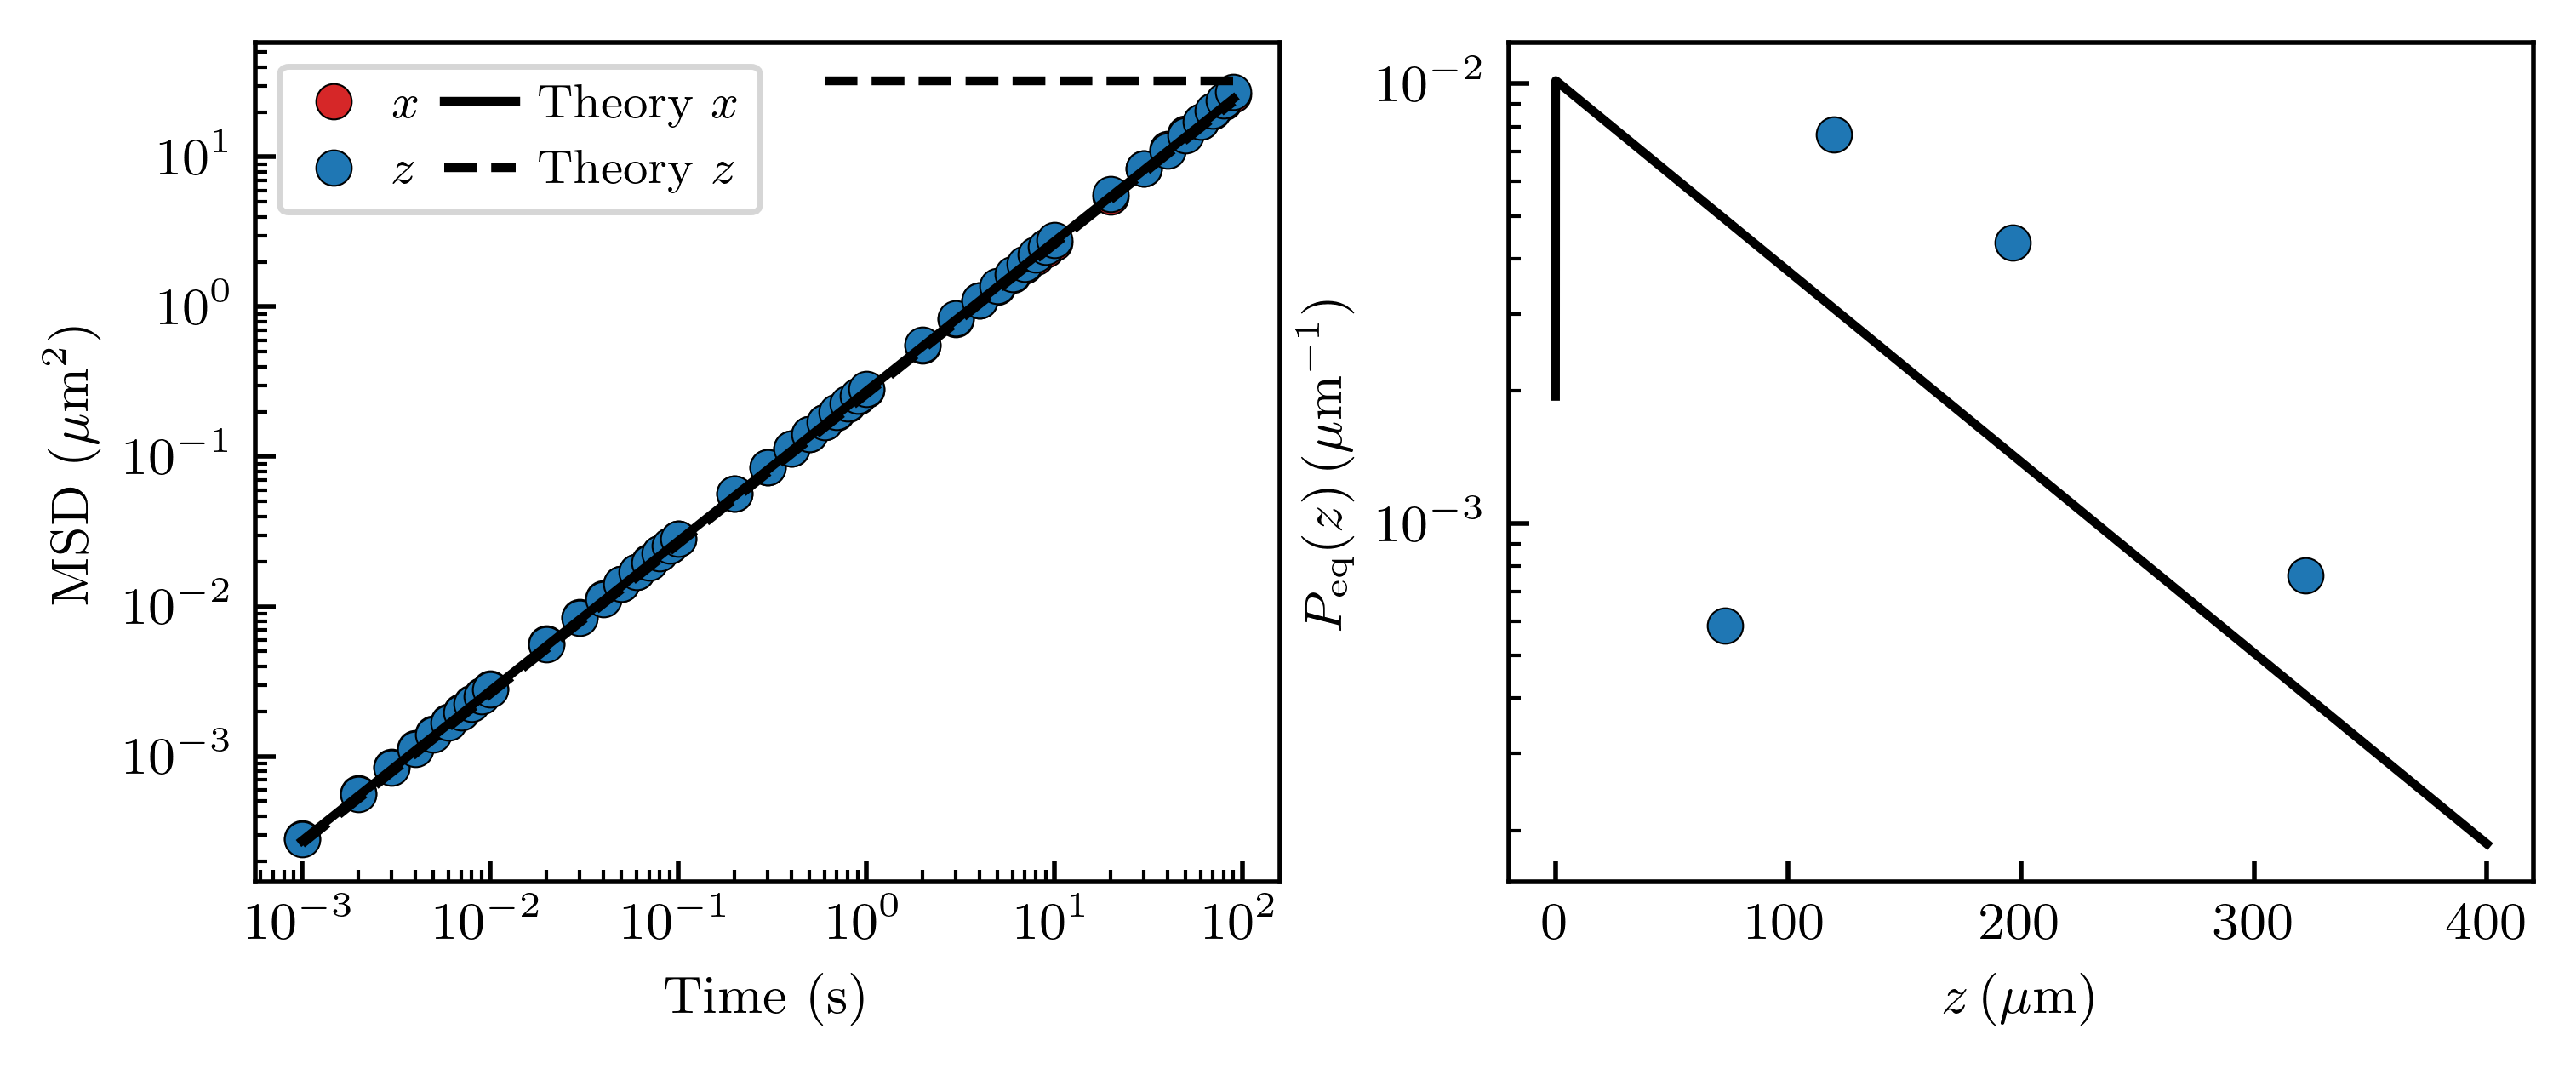

In [648]:
# Plot MSD, Peq

x_P_eq_theory = np.linspace(min_distance, max_distance, int(1e6))
y_P_eq_theory = P_eq(x_P_eq_theory, B, lD, lB, normalize=True)

fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(delta_time_MSD, MSD_x*1e12, 'o', mfc='tab:red', label=r'$x$')
axes[0].plot(delta_time_MSD, MSD_z*1e12, 'o', mfc='tab:blue', label=r'$z$')
axes[0].plot(delta_time_MSD, 2 * meanDx * delta_time_MSD * 1e12, ls='-', c='k', label=r'Theory $x$')
axes[0].plot(delta_time_MSD, 2 * meanDz * delta_time_MSD * 1e12, ls='--', c='k', label=r'Theory $z$')
dtime_MSD_long = delta_time_MSD[delta_time_MSD > 0.5]
axes[0].plot(dtime_MSD_long, np.ones_like(dtime_MSD_long) * plateau_MSDz * 1e12, ls='--', c='k')
axes[0].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
axes[0].set(xlabel='Time (s)', ylabel=r'MSD $(\mathrm{\mu m ^2})$', xscale='log', yscale='log')

axes[1].plot(x_P_eq*1e6, y_P_eq*1e-6, 'o', mfc='tab:blue')  
axes[1].plot(x_P_eq_theory*1e6, y_P_eq_theory*1e-6, ls='-', c='k')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$P_\mathrm{eq}(z) \, \mathrm{(\mu m ^{-1})}$', xscale='linear', yscale='log')

plt.tight_layout(pad=0.2)
plt.show()

In [649]:
# fig.savefig('fig_MSD_Peq.pdf', transparent=True)

In [650]:
prob_dx[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.69629776e+00, 9.39259552e+00, 2.81777866e+01,
       4.69629776e+01, 1.50281528e+02, 5.54163136e+02, 1.62491903e+03,
       4.09986795e+03, 1.03600329e+04, 2.53787931e+04, 5.78114254e+04,
       1.21347638e+05, 2.40741616e+05, 4.51647652e+05, 7.92453284e+05,
       1.30414780e+06, 2.01510623e+06, 2.91994192e+06, 3.98149776e+06,
       5.10310516e+06, 6.15114976e+06, 6.96857795e+06, 7.40800584e+06,
       7.42087369e+06, 6.97783435e+06, 6.15604799e+06, 5.11486469e+06,
       3.99111108e+06, 2.92034580e+06, 2.00391495e+06, 1.29616879e+06,
       7.86038142e+05, 4.50581592e+05, 2.42667098e+05, 1.21000112e+05,
       5.79992774e+04, 2.55807339e+04, 1.06183292e+04, 4.02003088e+03,
      

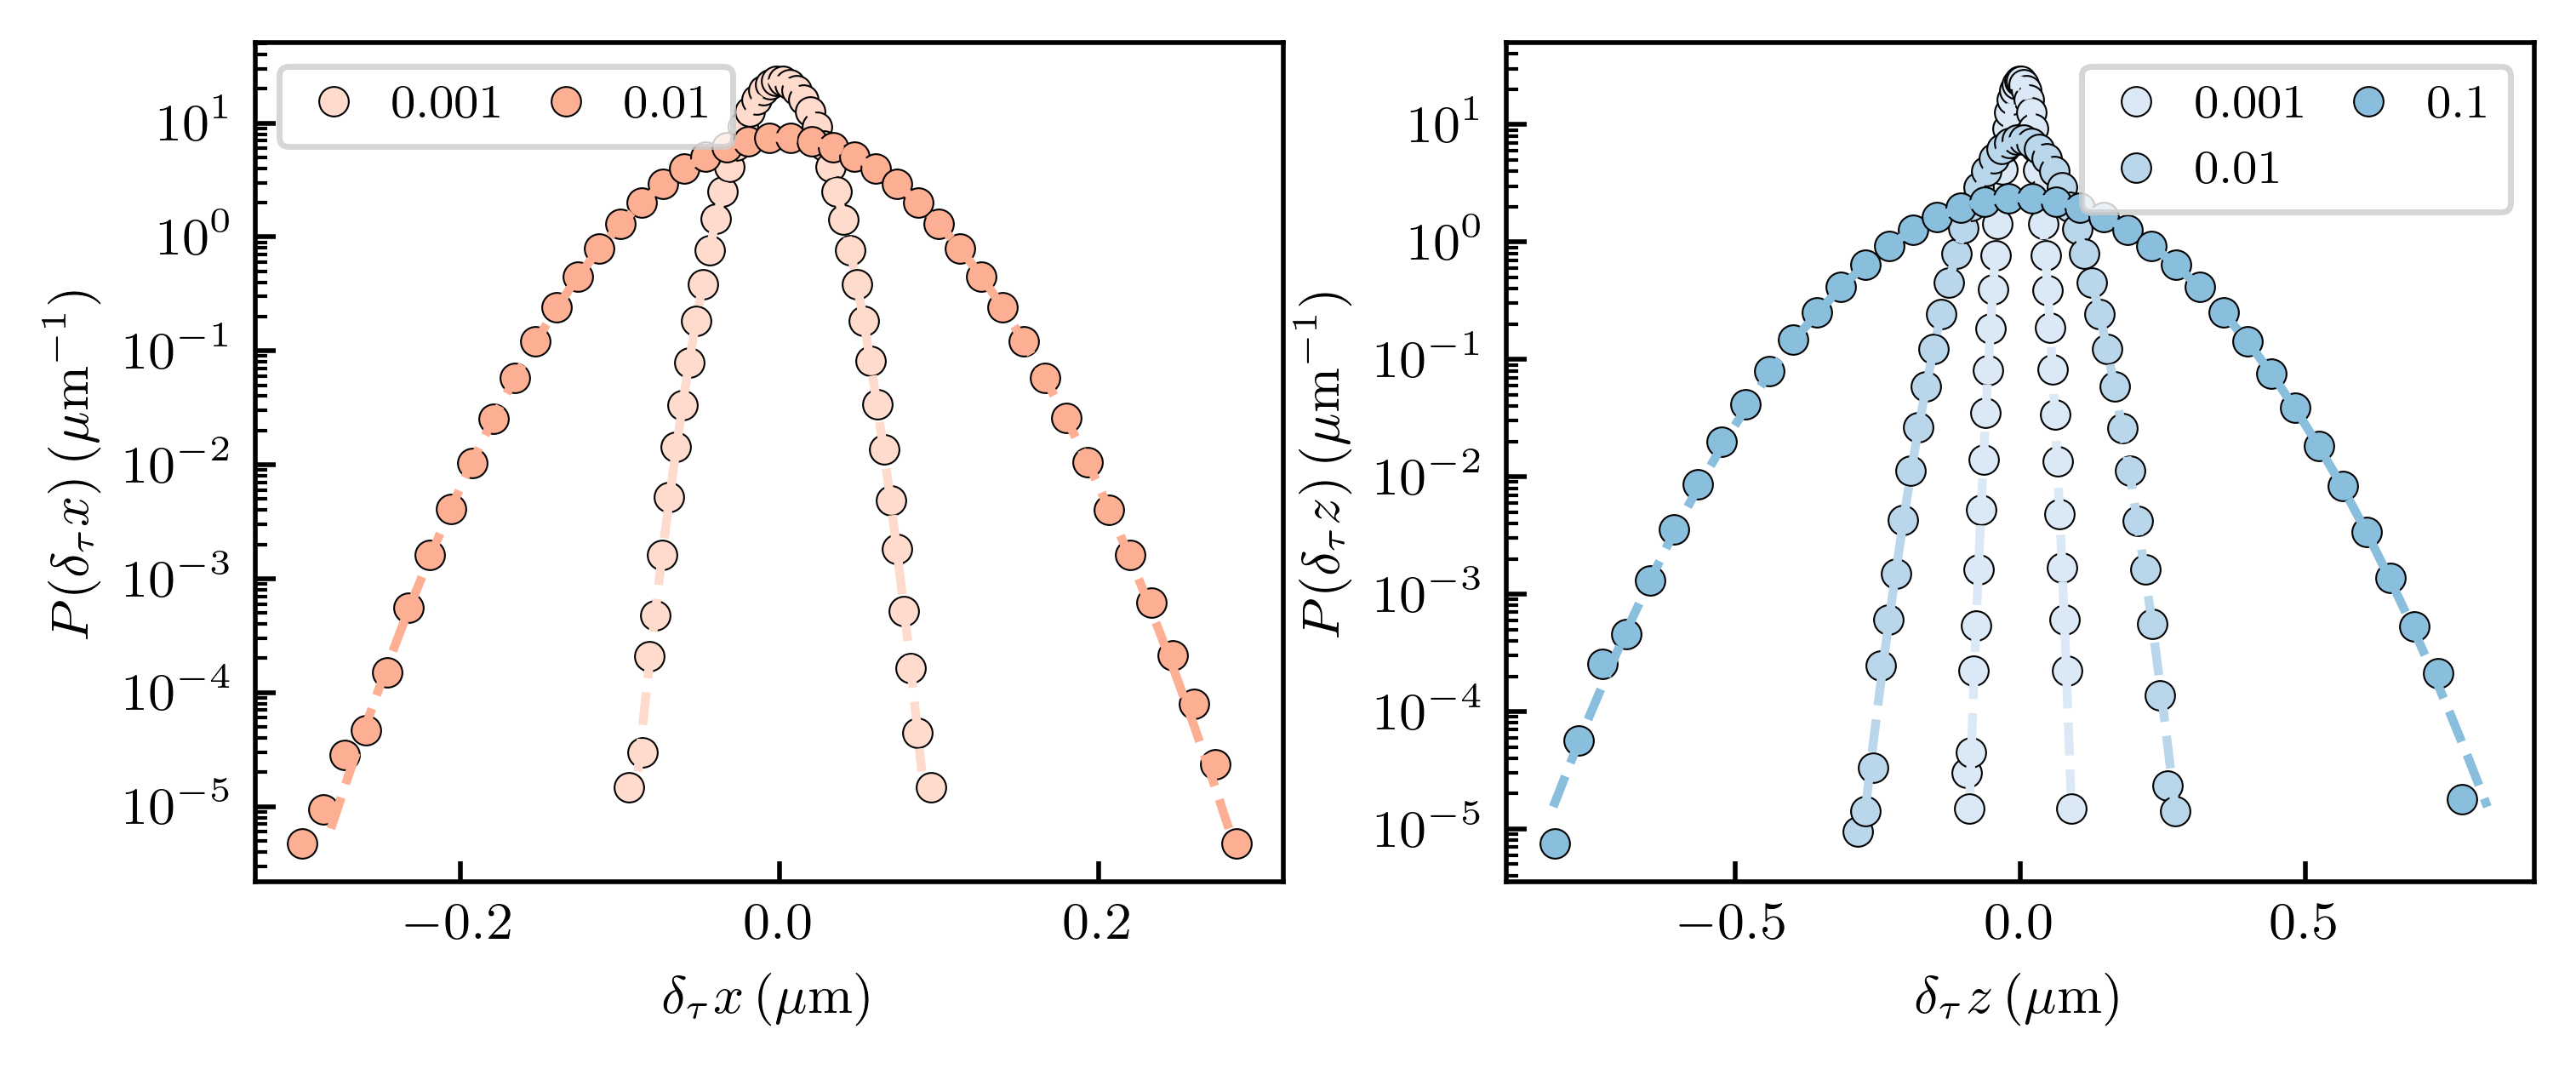

In [651]:
# Plot distributions of displacements 

def gaussian(x, D, tau):
    return 1 / np.sqrt(4 * np.pi * D * tau) * np.exp(- x ** 2 / (4 * D * tau))

bins_dx_theory = [np.linspace(-np.max([np.abs(np.min(bins)), np.max(bins)]), np.max([np.abs(np.min(bins)), np.max(bins)]), 100) for bins in bins_dx]
prob_dx_theory = [gaussian(bins_dx_theory[i], meanDx_MSD, timesteps_dx[i]*dt) for i in range(len(bins_dx))]

bins_dz_theory = [np.linspace(-np.max([np.abs(np.min(bins)), np.max(bins)]), np.max([np.abs(np.min(bins)), np.max(bins)]), 100) for bins in bins_dz]
prob_dz_theory = [gaussian(bins_dz_theory[i], meanDz_MSD, timesteps_dz[i]*dt) for i in range(len(bins_dz))]

colors_x = sns.color_palette("Reds", as_cmap=False)
colors_z = sns.color_palette("Blues", as_cmap=False)

fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

for i, di in enumerate(timesteps_dx[0:2]):
    bins, prob = bins_dx[i], prob_dx[i]
    cond = prob > 0
    bins = bins[cond]
    prob = prob[cond]
    bins_th, prob_th = bins_dx_theory[i], prob_dx_theory[i]
    axes[0].plot(bins * 1e6, prob*1e-6, 'o', ms=5, mfc=colors_x[i], label=np.round(di*dt,4))
    axes[0].plot(bins_th[prob_th >= np.min(prob)]*1e6, prob_th[prob_th >= np.min(prob)]*1e-6, ls='--', c=colors_x[i])
axes[0].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
axes[0].set(xlabel=r'$\delta_\tau x \, \mathrm{(\mu m)}$', ylabel=r'$P(\delta_\tau x) \, \mathrm{(\mu m^{-1})}$', xscale='linear', yscale='log')

for i, di in enumerate(timesteps_dz):
    bins, prob = bins_dz[i], prob_dz[i]
    cond = prob > 0
    bins = bins[cond]
    prob = prob[cond]
    bins_th, prob_th = bins_dz_theory[i], prob_dz_theory[i]
    axes[1].plot(bins * 1e6, prob*1e-6, 'o', ms=5, mfc=colors_z[i], label=np.round(di*dt,4)) 
    axes[1].plot(bins_th[prob_th >= np.min(prob)]*1e6, prob_th[prob_th >= np.min(prob)]*1e-6, ls='--', c=colors_z[i])
axes[1].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
axes[1].set(xlabel=r'$\delta_\tau z \, \mathrm{(\mu m)}$', ylabel=r'$P(\delta_\tau z) \, \mathrm{(\mu m^{-1})}$', xscale='linear', yscale='log')

plt.tight_layout(pad=0.2)
plt.show()

In [652]:
# fig.savefig('fig_distrib_displacements.pdf', transparent=True)

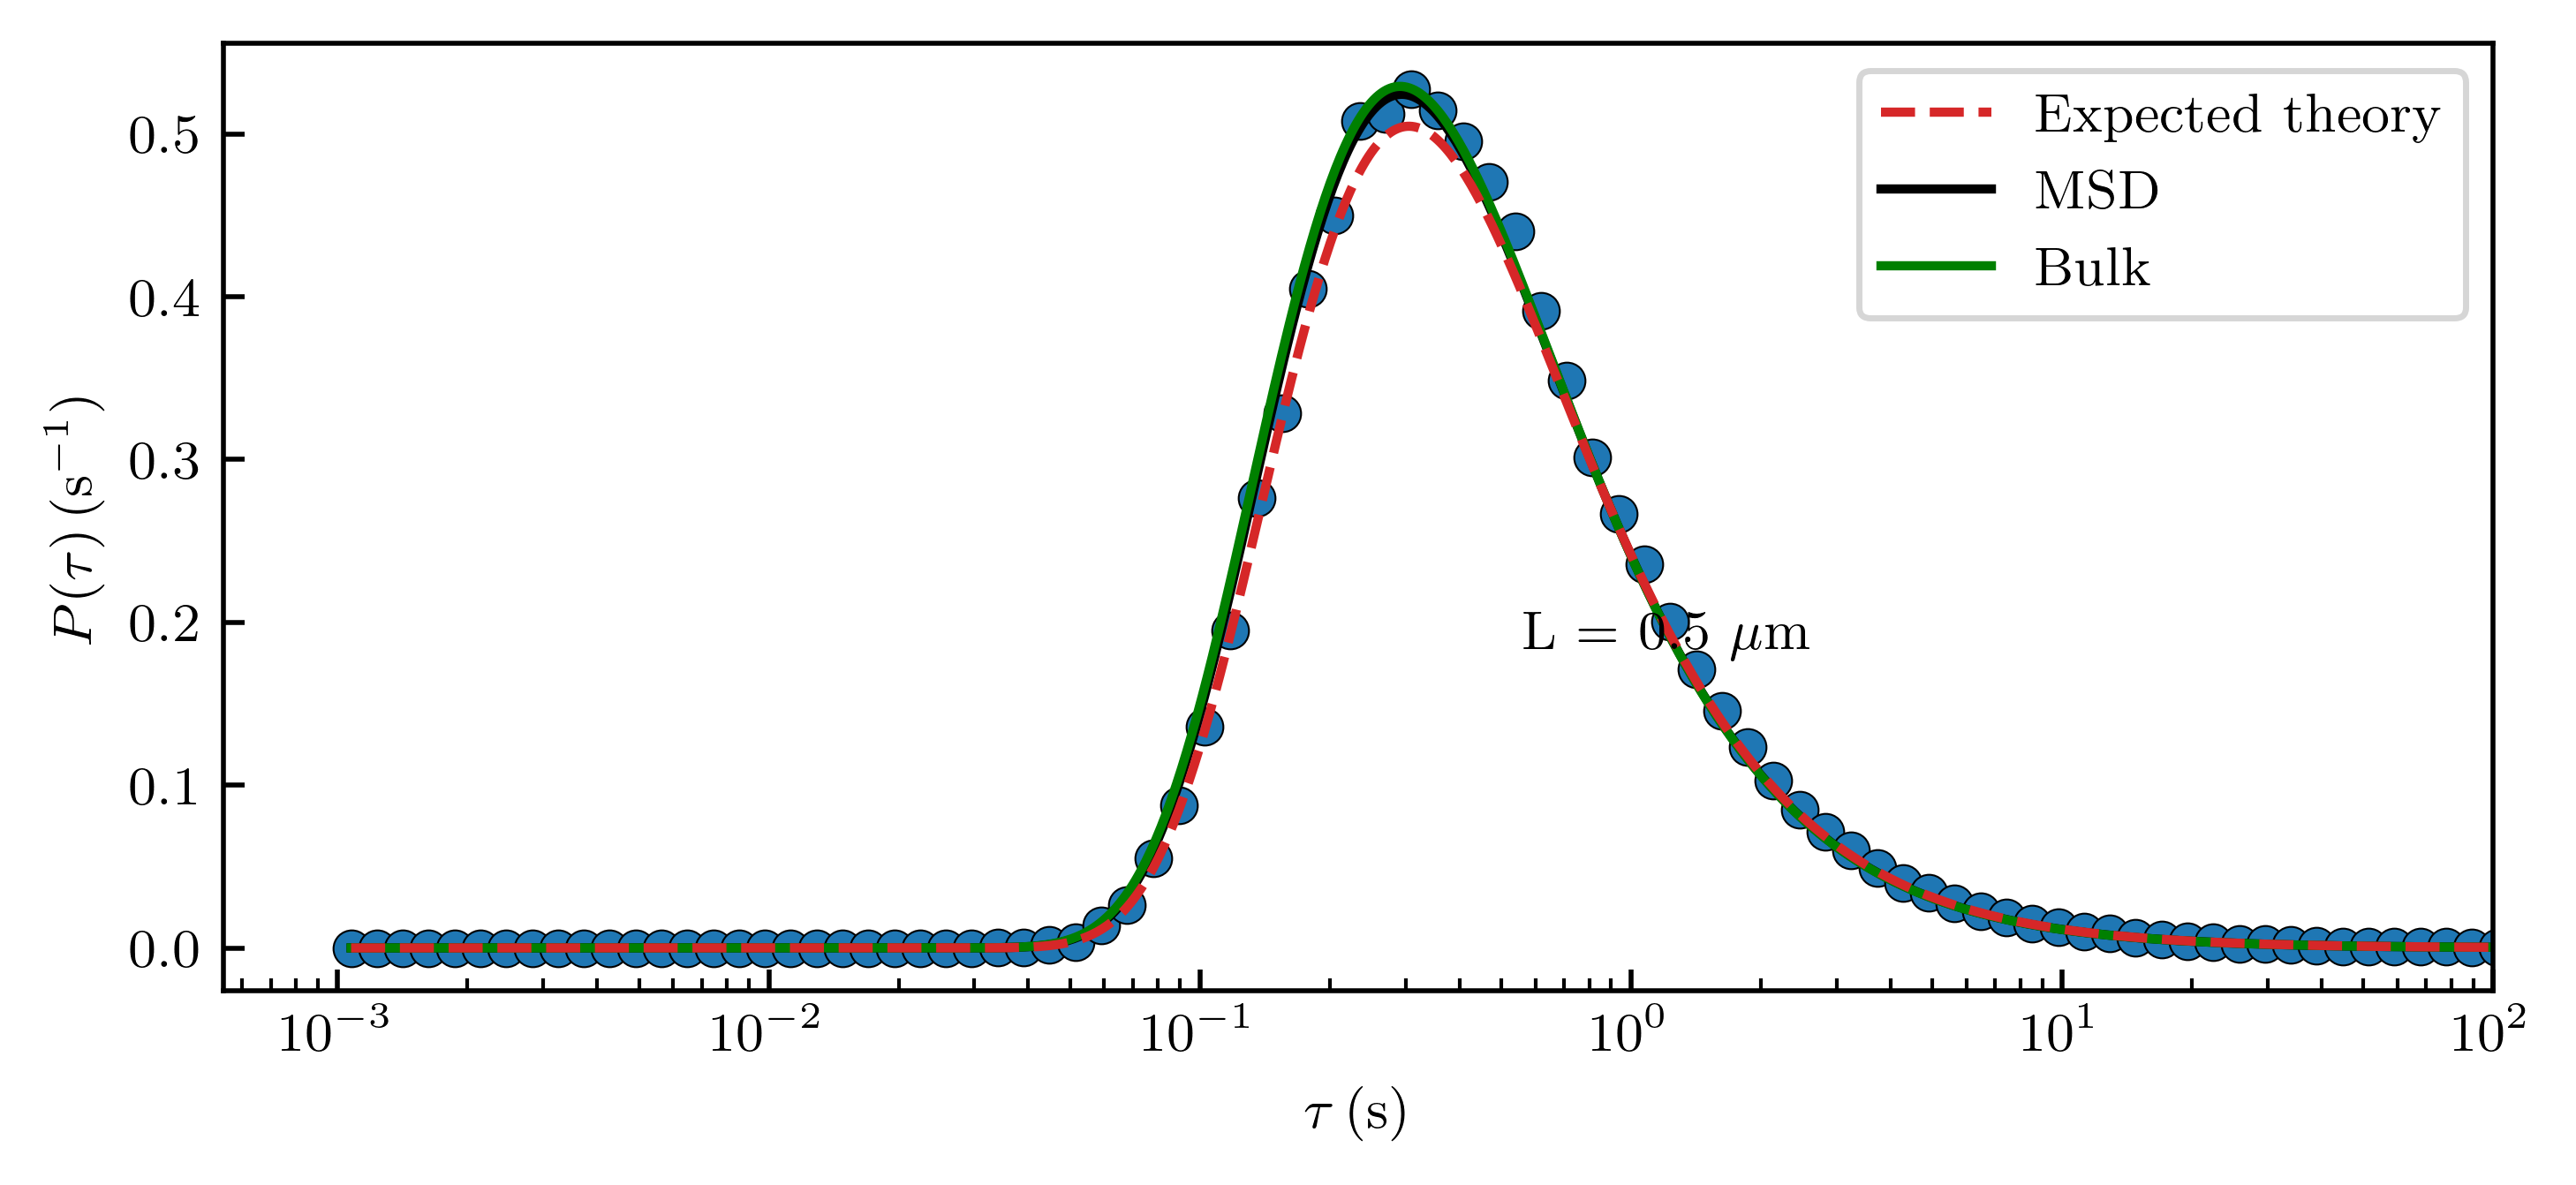

In [653]:
# Plot FPTs

k = 0

bins_FPT_x_theory = np.logspace(np.log10(np.min(bins_FPT_x[k])), np.log10(np.max(bins_FPT_x[k])), 1000)
hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=Ls[k], D=meanDx)

fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.plot(bins_FPT_x[k,:], hist_FPT_x[k,:], 'o')
ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--', c='tab:red', label=r'Expected theory', zorder=3)
# ax.plot(bins_FPT_x_theory, hist_FPT_x_fit, '--k', label='Fit')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=Ls[k], D=meanDx_MSD), '-k', label='MSD')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=Ls[k], D=D0), '-g', label='Bulk')
ax.set(xscale='log', yscale='linear', xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$', xlim=[None, 100])
ax.legend()
ax.annotate(
    r"L = {} $\mu$m".format(np.round(Ls[k] * 1e6, 3)), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.4), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
    fontsize=9, 
)
plt.tight_layout()
plt.show()

In [636]:
# fig.savefig('fig_FPT_L_0p4um.pdf', transparent=True)

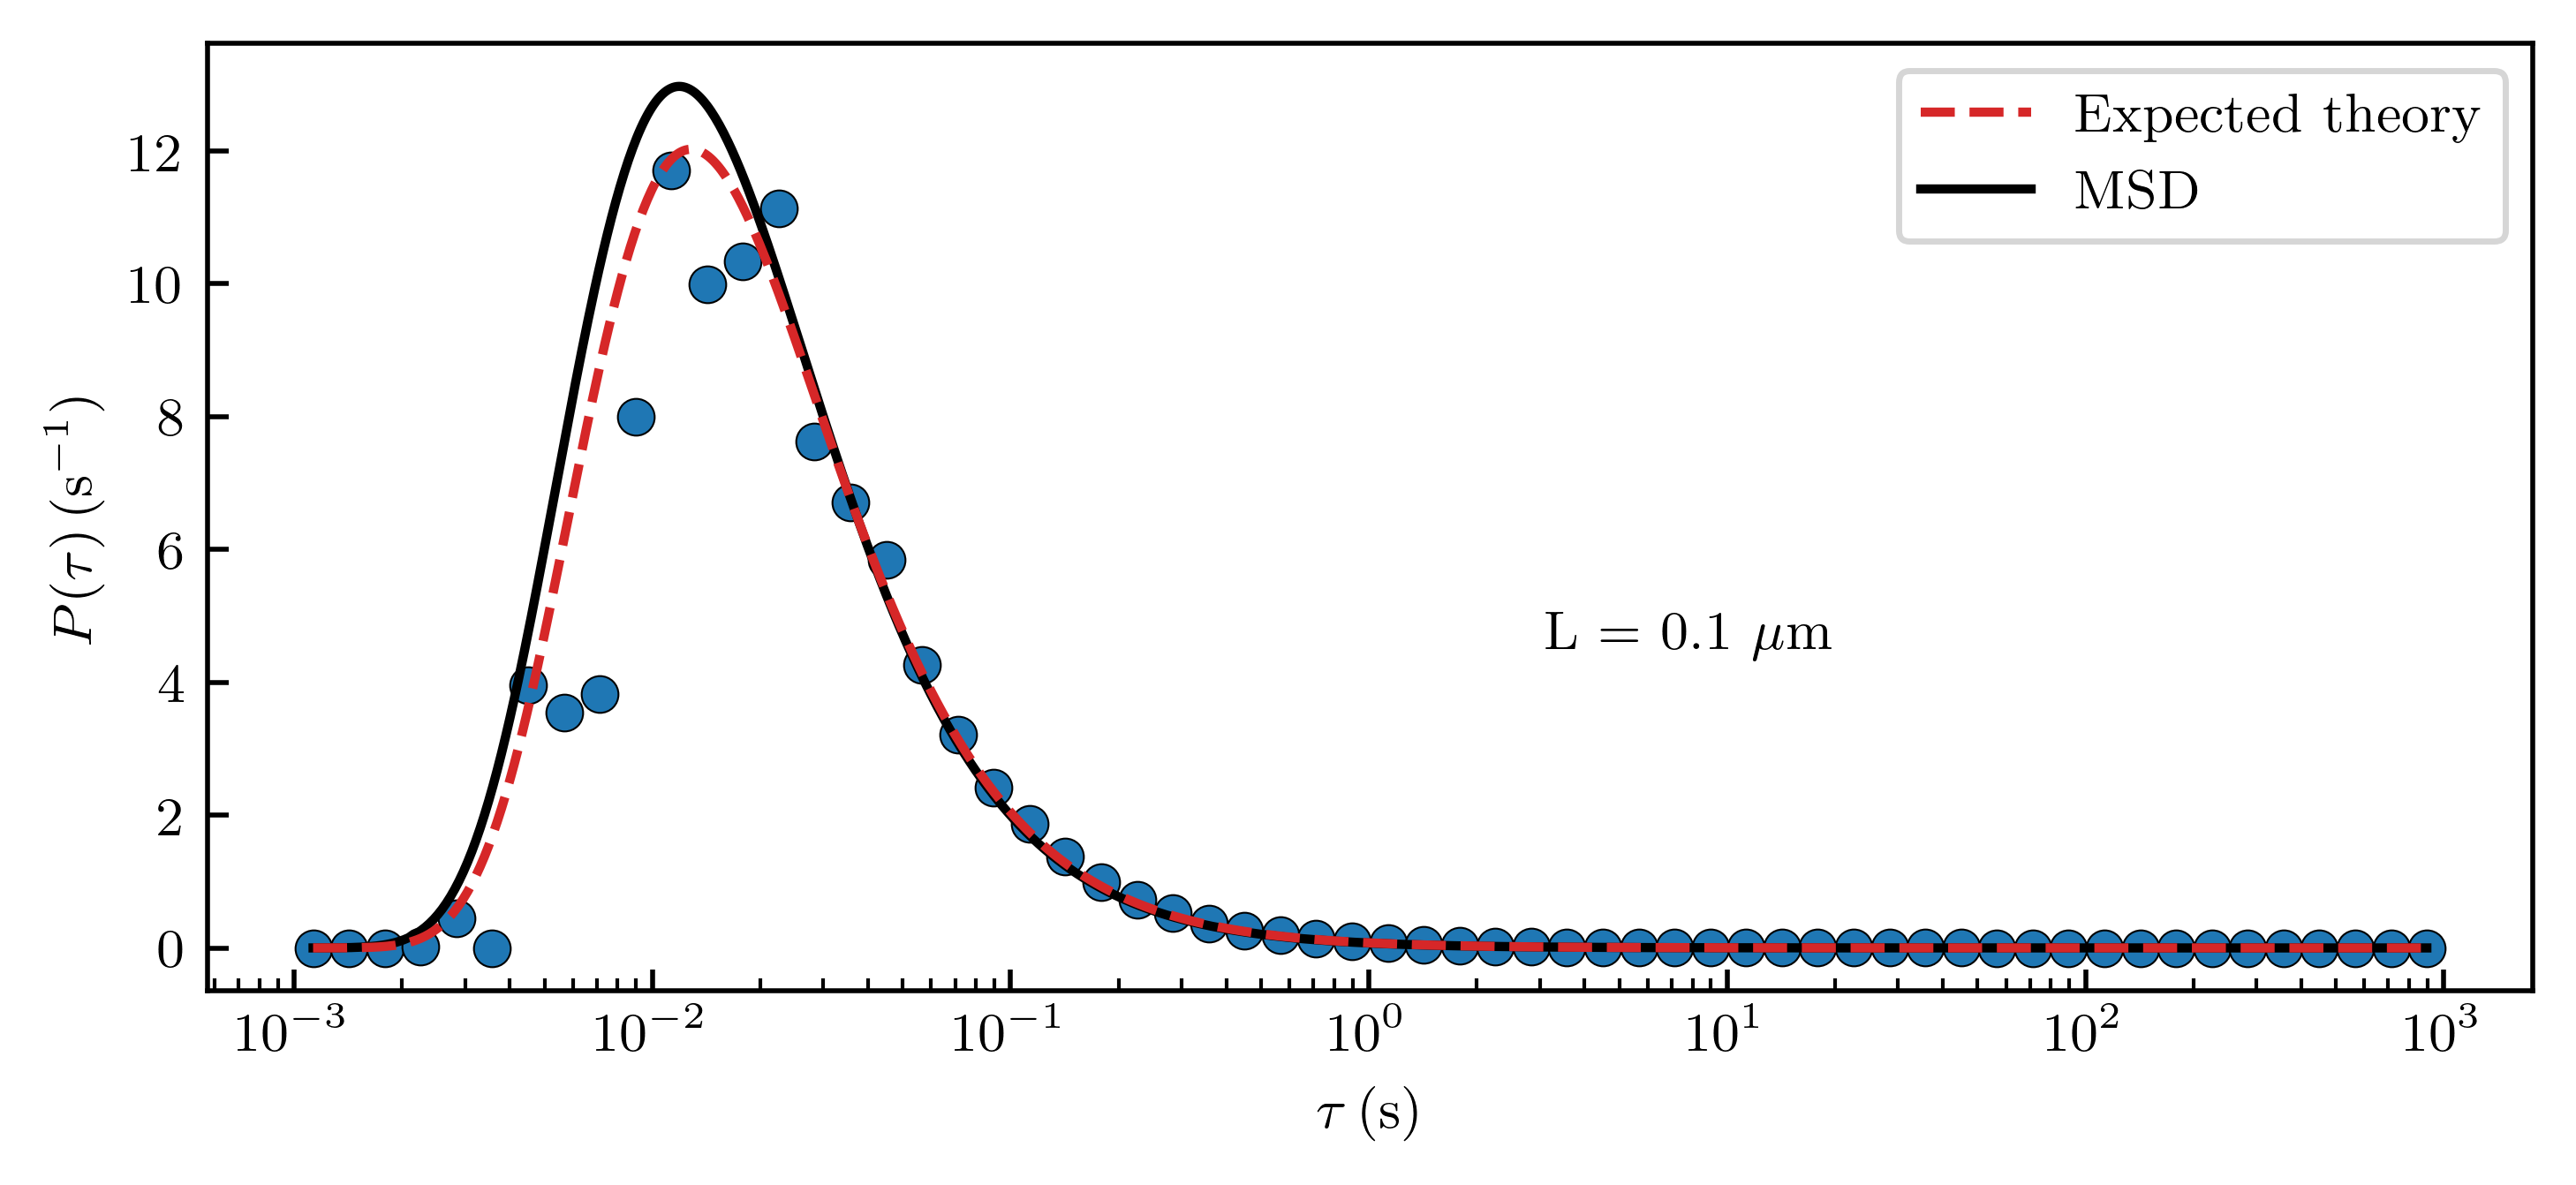

In [637]:
# Plot FPTs

k = 0

bins_FPT_z_theory = np.logspace(np.log10(np.min(bins_FPT_z[k])), np.log10(np.max(bins_FPT_z[k])), 1000)
hist_FPT_z_theory = Levy(bins_FPT_z_theory, L=Ls_z[k], D=meanDz)

fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.plot(bins_FPT_z[k,:], hist_FPT_z[k,:], 'o')
ax.plot(bins_FPT_z_theory, hist_FPT_z_theory, '--', c='tab:red', label=r'Expected theory', zorder=3)
# ax.plot(bins_FPT_x_theory, hist_FPT_x_fit, '--k', label='Fit')
ax.plot(bins_FPT_z_theory, Levy(bins_FPT_z_theory, L=Ls_z[k], D=meanDz_MSD), '-k', label='MSD')
ax.set(xscale='log', yscale='linear', xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$')
ax.legend()
ax.annotate(
    r"L = {} $\mu$m".format(np.round(Ls_z[k] * 1e6, 3)), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.4), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
    fontsize=9, 
)
plt.tight_layout()
plt.show()

In [638]:
# fig.savefig('fig_FPT_z_L_0p2um.pdf', transparent=True)

In [639]:
# save = {}

save['a'] = a
save['H'] = H
save['B'] = B
save['lD'] = lD
save['lB'] = lB
save['rho_m'] = rho_m
save['rho_p'] = rho_p
save['drho'] = drho
save['eta0'] = eta0
save['kT'] = kT

save['N1'] = N1
save['N2'] = N2
save['Nt'] = Nt
save['dt'] = dt
save['dt_num'] = dt_num
save['Nt_sub'] = Nt_sub

save['delta_frame_nb'] = np.copy(delta_frame_nb)
save['delta_time_MSD'] = np.copy(delta_time_MSD)
save['MSD_x'] = np.copy(MSD_x)
save['MSD_z'] = np.copy(MSD_z)
save['mean_Dx_MSD'] = np.copy(mean_Dx_MSD)
save['mean_Dz_MSD'] = np.copy(mean_Dz_MSD)

save['x_P_eq'] = np.copy(x_P_eq)
save['y_P_eq'] = np.copy(y_P_eq)

save['timesteps_dx'] = np.copy(timesteps_dx)
save['timesteps_dz'] = np.copy(timesteps_dz)
save['n_std'] = n_std
save['bins_dx'] = np.copy(bins_dx)
save['bins_dz'] = np.copy(bins_dz)
save['prob_dx'] = np.copy(prob_dx)
save['prob_dz'] = np.copy(prob_dz)

save['Ls'] = copy.deepcopy(Ls)
save['bins_FPT_x'] = np.copy(bins_FPT_x)
save['hist_FPT_x'] = np.copy(hist_FPT_x)
save['Ls_z'] = copy.deepcopy(Ls_z)
save['bins_FPT_z'] = np.copy(bins_FPT_z)
save['hist_FPT_z'] = np.copy(hist_FPT_z)


# Theoretical = expected values 
save['mean_Dx_theory'] = meanDx
save['mean_Dz_theory'] = meanDz
save['plateau_MSDz_theory'] = plateau_MSDz
save['x_P_eq_theory'] = np.copy(x_P_eq_theory)
save['y_P_eq_theory'] = np.copy(y_P_eq_theory)

In [347]:
# savemat('simu_PS_3um_lD_15nm_5.mat', save)